In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Auxiliares

In [2]:
import requests
from bs4 import BeautifulSoup
import zipfile
import io
import os

def baixar_shapefile_estado(estado):
    base_url = f'https://catalog.data.gov/dataset/tiger-line-shapefile-2021-state-{estado}-census-tracts'
    response = requests.get(base_url)
    if response.status_code != 200:
        return None
    soup = BeautifulSoup(response.text, 'html.parser')
    link_tag = soup.find('a', href=lambda href: href and href.endswith('.zip'))
    if not link_tag:
        return None
    download_url = link_tag['href']
    if not download_url.startswith('http'):
        download_url = 'https://catalog.data.gov' + download_url
    zip_response = requests.get(download_url)
    if zip_response.status_code != 200:
        return None
    with zipfile.ZipFile(io.BytesIO(zip_response.content)) as zip_ref:
        zip_ref.extractall('/content/')


In [3]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io, os
drive_service = build("drive", "v3")

def download_from_folder_by_name(service, folder_id: str, filename: str, dest_path: str):
    q = f"'{folder_id}' in parents and name = '{filename}' and trashed = false"
    res = service.files().list(
        q=q,
        fields="files(id,name,size,mimeType)",
        supportsAllDrives=True,
        includeItemsFromAllDrives=True,
        pageSize=1,
    ).execute()
    files = res.get("files", [])
    if not files:
        raise FileNotFoundError(f"Arquivo não encontrado na pasta {folder_id}: {filename}")

    file_id = files[0]["id"]
    os.makedirs(os.path.dirname(dest_path), exist_ok=True)

    request = service.files().get_media(fileId=file_id, supportsAllDrives=True)
    with open(dest_path, "wb") as fh:
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()
    return dest_path

# Alabama


Census: https://catalog.data.gov/dataset/tiger-line-shapefile-2021-state-alabama-census-tracts

In [ ]:
ESTADO = "Alabama"

In [ ]:
diretorio_principal = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/"

In [ ]:
baixar_shapefile_estado("alabama")

<Axes: >

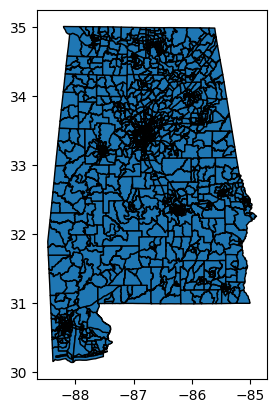

In [ ]:
import os
import geopandas as gpd

arquivos = [os.path.join("/content", f) for f in os.listdir("/content") if f.endswith(".shp")]
arquivo = max(arquivos, key=os.path.getmtime)
tl = gpd.read_file(arquivo).to_crs("EPSG:4326")
tl.plot(edgecolor="black")


In [ ]:
tl[["GEOID","geometry"]] ##TODO: Passar arquivo para HGI (CSV)

## BORO -> GEOID

,GEOID,geometry
0,01079979201,"POLYGON ((-87.43611 34.72743, -87.4361 34.7274..."
1,01079979202,"POLYGON ((-87.45696 34.61352, -87.45693 34.613..."
2,01079979502,"POLYGON ((-87.29614 34.54337, -87.2961 34.5434..."
3,01079979501,"POLYGON ((-87.20741 34.5571, -87.2074 34.55731..."
4,01009050103,"POLYGON ((-86.57229 33.8207, -86.57229 33.8208..."
...,...,...
1432,01087232200,"POLYGON ((-86.02316 32.41927, -86.02312 32.419..."
1433,01087232000,"POLYGON ((-85.71336 32.44663, -85.71318 32.447..."
1434,01087231500,"POLYGON ((-85.88615 32.49305, -85.88575 32.493..."
1435,01087231400,"POLYGON ((-85.64797 32.44458, -85.64626 32.445..."


In [ ]:
import geopandas as gpd
from shapely import wkt

boroughs = tl[["GEOID", "geometry"]].copy()
boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)

boroughs.to_csv(f"{diretorio_principal}/boroughs_area.csv", index=False)


/tmp/ipython-input-2001046065.py:5: UserWarning: Geometry column does not contain geometry.
  boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)


In [ ]:
boroughs

,GEOID,geometry
0,01079979201,"POLYGON ((-87.436107 34.727427, -87.436104 34...."
1,01079979202,"POLYGON ((-87.45696 34.613518, -87.456933 34.6..."
2,01079979502,"POLYGON ((-87.296137 34.543373, -87.296104 34...."
3,01079979501,"POLYGON ((-87.20741 34.557097, -87.2074 34.557..."
4,01009050103,"POLYGON ((-86.572293 33.820705, -86.572291 33...."
...,...,...
1432,01087232200,"POLYGON ((-86.023164 32.419268, -86.02312 32.4..."
1433,01087232000,"POLYGON ((-85.713356 32.446634, -85.713179 32...."
1434,01087231500,"POLYGON ((-85.886148 32.493053, -85.885746 32...."
1435,01087231400,"POLYGON ((-85.647973 32.444578, -85.64626 32.4..."


In [ ]:
!rm -rf /usr/local/lib/python3.12/dist-packages/~orch*
!pip cache purge


Files removed: 0


In [ ]:
%pip -q install -U pip setuptools wheel
%pip -q uninstall -y torch torchvision torchaudio torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib
%pip -q install --no-cache-dir geopandas shapely libpysal h3 h3ronpy pyarrow scipy scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 77.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
%pip -q install --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cpu
%pip -q install --no-cache-dir pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.4.0+cpu.html


In [ ]:
%cd {diretorio_principal}

/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main


## POI Embedding

In [ ]:
FOLDER_ID_CRUS = "1cV807NNGn4gSDX-7fkJ83rlr0nRo4y89"
FOLDER_ID_SEPARATED = "1XUWhd59YDe8dSrTb6eZlLvhVcLSGpZ7n"

filename = f"checkins_{ESTADO}.csv"

path_crus = f"estados/crus/{filename}"
path_sep  = f"estados/separated/{filename}"

print("Baixando (crus)...")
download_from_folder_by_name(drive_service,FOLDER_ID_CRUS, filename, path_crus)

print("Baixando (separated)...")
download_from_folder_by_name(drive_service,FOLDER_ID_SEPARATED, filename, path_sep)

print("Concluído:", path_crus, "e", path_sep)


Baixando (crus)...
Baixando (separated)...
Concluído: estados/crus/checkins_Alabama.csv e estados/separated/checkins_Alabama.csv


In [ ]:
import pandas as pd, numpy as np, ast
import geopandas as gpd
from shapely.geometry import Point


CHECKIN_NAO_CRU = f"estados/crus/checkins_{ESTADO}.csv"
CHECKIN_CRU     = f"estados/separated/checkins_{ESTADO}.csv"
OUT_POIS        = "pois_gowalla.csv"

df_labeled = pd.read_csv(CHECKIN_NAO_CRU)
df_raw     = pd.read_csv(CHECKIN_CRU)

lon_col_raw = "lng" if "lng" in df_raw.columns else "longitude"
lat_col_raw = "lat" if "lat" in df_raw.columns else "latitude"
lon_col_lab = "lng" if "lng" in df_labeled.columns else ("longitude" if "longitude" in df_labeled.columns else None)
lat_col_lab = "lat" if "lat" in df_labeled.columns else ("latitude" if "latitude" in df_labeled.columns else None)

def parse_names(cell):
    try:
        lst = ast.literal_eval(cell)
        if isinstance(lst, list):
            return [d.get("name") for d in lst if isinstance(d, dict) and "name" in d]
    except Exception:
        pass
    return []

df_raw["__cat_names"] = df_raw["spot_categories"].fillna("[]").apply(parse_names)

def first_or_none(lst):
    return lst[0] if (isinstance(lst, list) and len(lst) > 0) else None

df_raw["__fclass_name"] = df_raw["__cat_names"].apply(first_or_none)

fclass_by_place = (df_raw.dropna(subset=["__fclass_name"])
                          .groupby("placeid")["__fclass_name"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

cat_by_place = (df_labeled.dropna(subset=["category"])
                          .groupby("placeid")["category"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

coords_raw = (df_raw.groupby("placeid")[[lat_col_raw, lon_col_raw]]
                    .mean()
                    .rename(columns={lat_col_raw: "latitude", lon_col_raw: "longitude"}))

if coords_raw.empty and lon_col_lab and lat_col_lab and (lon_col_lab in df_labeled.columns) and (lat_col_lab in df_labeled.columns):
    coords_raw = (df_labeled.groupby("placeid")[[lat_col_lab, lon_col_lab]]
                           .mean()
                           .rename(columns={lat_col_lab: "latitude", lon_col_lab: "longitude"}))

coords_raw = coords_raw.dropna()

pois = pd.DataFrame({"feature_id": coords_raw.index})
pois["feature_id"] = pois["feature_id"].astype(int)

pois["fclass_name"]   = fclass_by_place.reindex(pois["feature_id"]).values
pois["category_name"] = cat_by_place.reindex(pois["feature_id"]).values

pois = pois.dropna(subset=["fclass_name", "category_name"]).reset_index(drop=True)

gdf = gpd.GeoDataFrame(
    pois,
    geometry=gpd.points_from_xy(coords_raw.loc[pois["feature_id"], "longitude"].values,
                                coords_raw.loc[pois["feature_id"], "latitude"].values),
    crs="EPSG:4326"
)
gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)

fclass_vocab = {n:i for i,n in enumerate(pd.Series(gdf["fclass_name"]).dropna().unique())}
cat_vocab    = {n:i for i,n in enumerate(pd.Series(gdf["category_name"]).dropna().unique())}

gdf["fclass"]   = gdf["fclass_name"].map(lambda n: fclass_vocab.get(n, -1)).astype(int)
gdf["category"] = gdf["category_name"].map(lambda n: cat_vocab.get(n, -1)).astype(int)

gdf = gdf[(gdf["fclass"]>=0) & (gdf["category"]>=0)].reset_index(drop=True)

pois_out = gdf[["feature_id", "category", "fclass", "geometry"]].copy()
pois_out.to_csv(OUT_POIS, index=False)



/tmp/ipython-input-2811998353.py:67: UserWarning: Geometry column does not contain geometry.
  gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)


In [ ]:
# @title
import geopandas as gpd
from shapely.geometry import box

lat_min, lat_max = df["latitude"].min(), df["latitude"].max()
lon_min, lon_max = df["longitude"].min(), df["longitude"].max()
area = box(lon_min, lat_min, lon_max, lat_max).buffer(0.01)

boroughs = gpd.GeoDataFrame(geometry=[area], crs="EPSG:4326")

boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)
boroughs.to_csv("boroughs_area.csv", index=False)


In [ ]:
import sys
module_dir = f'{diretorio_principal}/region-embedding/baselines/poi-encoder'

sys.path.insert(0, module_dir)

In [ ]:
from POIEmbedding import PreProcess

PreProcess("pois_gowalla.csv", "boroughs_area.csv", h3=False).run() ##TODO H3 FALSO


boroughs cols: ['GEOID', 'geometry']
        GEOID                                           geometry
0  1079979201  POLYGON ((-87.43611 34.72743, -87.4361 34.7274...
1  1079979202  POLYGON ((-87.45696 34.61352, -87.45693 34.613...
2  1079979502  POLYGON ((-87.29614 34.54337, -87.2961 34.5434...
3  1079979501  POLYGON ((-87.20741 34.5571, -87.2074 34.55731...
4  1009050103  POLYGON ((-86.57229 33.8207, -86.57229 33.8208...
           GEOID                                           geometry
0     1079979201  POLYGON ((-87.43611 34.72743, -87.4361 34.7274...
1     1079979202  POLYGON ((-87.45696 34.61352, -87.45693 34.613...
2     1079979502  POLYGON ((-87.29614 34.54337, -87.2961 34.5434...
3     1079979501  POLYGON ((-87.20741 34.5571, -87.2074 34.55731...
4     1009050103  POLYGON ((-86.57229 33.8207, -86.57229 33.8208...
...          ...                                                ...
1432  1087232200  POLYGON ((-86.02316 32.41927, -86.02312 32.419...
1433  1087232000  POLYGON ((-

In [ ]:
from POIEmbedding import POI2Vec
p = POI2Vec()
p.train()
p.save_walks()


       source  target    weight
0           0    9801  0.489154
1           0    9537  0.489154
2           0    9591  0.576713
3           0    3260  0.587017
4           0    4845  0.566219
...       ...     ...       ...
30777   10238   10239  0.631456
30778   10238   10240  0.414344
30779   10239   10242  0.451068
30780   10239   10240  0.421236
30781   10255   10259  0.386090

[30782 rows x 3 columns]


In [ ]:
from POIEmbedding import POI2Vec
from model import POISet, EmbeddingModel
import torch, torch.utils.data as tud

poi2vec = POI2Vec()
poi2vec.read_walks()
poi2vec.get_global_second_class_walks()

second_class_hierarchy_pairs = list(set([tuple(x) for x in poi2vec.pois[["category","fclass"]].to_numpy()]))
dataset = POISet(
    poi2vec.second_class_number,
    poi2vec.second_class_walks,
    poi2vec.global_second_class_walks,
    k=5
)
model = EmbeddingModel(
    vocab_size=poi2vec.second_class_number,
    embed_size=64,
    second_class_hierarchy_pairs=second_class_hierarchy_pairs,
    le_lambda=1e-8
)

loader = tud.DataLoader(dataset, batch_size=2048, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-2)
for e in range(5):
    for i,(inp,pos,neg) in enumerate(loader):
        opt.zero_grad()
        loss,_ = model(inp.long(), pos.long(), neg.long())
        loss.backward()
        opt.step()

torch.save({"in_embed.weight": model.clone_input_embedding()}, "poi-encoder-gowalla-h3.tensor")


       source  target    weight
0           0    9801  0.489154
1           0    9537  0.489154
2           0    9591  0.576713
3           0    3260  0.587017
4           0    4845  0.566219
...       ...     ...       ...
30777   10238   10239  0.631456
30778   10238   10240  0.414344
30779   10239   10242  0.451068
30780   10239   10240  0.421236
30781   10255   10259  0.386090

[30782 rows x 3 columns]


## HGI

In [ ]:
import sys
module_dir = f'{diretorio_principal}/region-embedding/baselines/HGI/preprocess'

sys.path.insert(0, module_dir)

In [ ]:
POIS = "pois_gowalla.csv"
REGS = "boroughs_area.csv"
EMB  = "poi-encoder-gowalla-h3.tensor"

from main import Preprocess
data_dict = Preprocess(POIS, REGS, EMB, h3=False).get_data_torch()

import torch, pickle
from torch_geometric.data import Data

g = Data(
    x=torch.tensor(data_dict['node_features'], dtype=torch.float32),
    edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
    edge_weight=torch.tensor(data_dict['edge_weight'], dtype=torch.float32),
)
g.region_id  = torch.tensor(data_dict['region_id'], dtype=torch.long)
g.region_area = torch.tensor(data_dict['region_area'], dtype=torch.float32)
g.coarse_region_similarity = torch.tensor(data_dict['coarse_region_similarity'], dtype=torch.float32)
g.region_adjacency = torch.tensor(data_dict['region_adjacency'], dtype=torch.long)

torch.save(g, "gowalla.pt")


reading poi data
reading boroughs data


/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 16 disconnected components.
 There are 7 islands with ids: 131, 288, 310, 775, 863, 865, 1065.
  return W(neighbors, **kwargs)


reading boroughs data
creating graph
       feature_id  category  fclass                    geometry  index_right  \
0            9531         0       0  POINT (-86.80362 33.38157)         1322   
1            9532         1       1  POINT (-86.80523 33.38792)          151   
2            9533         2       2  POINT (-86.79326 33.38684)         1322   
3            9593         3       3  POINT (-86.75109 33.56114)          149   
4            9693         4       4  POINT (-86.77925 33.48669)          438   
...           ...       ...     ...                         ...          ...   
10264     7565433         6      79  POINT (-87.67046 34.76912)         1234   
10265     7568997         0      51  POINT (-85.01443 32.49563)          686   
10266     7570992         3      49  POINT (-87.68579 30.26555)          904   
10267     7574223         6      44  POINT (-86.84374 34.17847)           44   
10268     7574363         0      86   POINT (-86.7737 33.51502)          492   

  

/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main//region-embedding/baselines/HGI/preprocess/main.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

creating region adjacency


/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 16 disconnected components.
 There are 7 islands with ids: 131, 288, 310, 775, 863, 865, 1065.
  return W(neighbors, **kwargs)


creating region similarity by cosine similarity of embeddings
finishing preprocessing


In [ ]:
import os, pickle as pkl, torch
from torch_geometric.data import Data

os.makedirs("./data", exist_ok=True)

g = torch.load("./gowalla.pt", map_location="cpu")

data_dict = {
    "node_features": g.x.detach().cpu().numpy(),
    "edge_index": g.edge_index.detach().cpu().numpy(),
    "edge_weight": g.edge_weight.detach().cpu().numpy(),
    "region_id": g.region_id.detach().cpu().numpy(),
    "region_area": g.region_area.detach().cpu().numpy(),
    "coarse_region_similarity": g.coarse_region_similarity.detach().cpu().numpy(),
    "region_adjacency": g.region_adjacency.detach().cpu().numpy(),
}

with open("./data/gowalla_hgi_data.pkl", "wb") as f:
    pkl.dump(data_dict, f)



/tmp/ipython-input-1595378934.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load("./gowalla.pt", map_location="cpu")


In [ ]:
import numpy as np

R_from_id = int(np.max(data_dict["region_id"])) + 1
R_area    = len(data_dict["region_area"])
R_adj     = int(data_dict["region_adjacency"].max()) + 1
R_sim     = data_dict["coarse_region_similarity"].shape[0]

print("R from id :", R_from_id)
print("R area    :", R_area)
print("R adj     :", R_adj)
print("R sim     :", R_sim)

assert R_from_id == R_area == R_adj == R_sim, "Desalinhad"


R from id : 1072
R area    : 1072
R adj     : 1072
R sim     : 1072


In [ ]:
!python {diretorio_principal}/region-embedding/baselines/HGI/train.py --city gowalla --dim 64 --alpha 0.5 --attention_head 4 --epoch 300 --device cpu --save_name gowalla_h3


Streaming output truncated to the last 5000 lines.
        [-0.0589, -0.1058,  0.1062,  ..., -0.0212, -0.0732, -0.0831]],
       requires_grad=True) Parameter containing:
tensor([[ 0.0827,  0.0289,  0.0861,  ..., -0.1193,  0.0861, -0.1299],
        [ 0.0321,  0.0090, -0.0654,  ..., -0.0215,  0.1011, -0.0533],
        [ 0.0735, -0.0223, -0.0821,  ...,  0.0650,  0.1418,  0.1156],
        ...,
        [-0.0668, -0.0182, -0.1140,  ..., -0.0661,  0.0995,  0.0161],
        [-0.0617,  0.1053,  0.0125,  ...,  0.1208,  0.1508, -0.0242],
        [-0.0711,  0.0705, -0.0693,  ..., -0.0519, -0.0265, -0.0844]],
       requires_grad=True)
Parameter containing:
tensor([[-0.0114,  0.1129,  0.1022,  ..., -0.0737,  0.1282,  0.0185],
        [-0.0914, -0.0067, -0.0799,  ...,  0.0517, -0.0958,  0.0691],
        [ 0.0317, -0.0202, -0.0250,  ..., -0.0401, -0.0520, -0.0401],
        ...,
        [-0.0625,  0.0353, -0.0902,  ..., -0.1227,  0.0595, -0.1043],
        [ 0.0882,  0.0652, -0.0675,  ...,  0.1017, -0

# California


Census: https://catalog.data.gov/dataset/tiger-line-shapefile-2021-state-alabama-census-tracts

In [ ]:
ESTADO = "California"

In [ ]:
diretorio_principal = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/"

In [ ]:
baixar_shapefile_estado("california")

<Axes: >

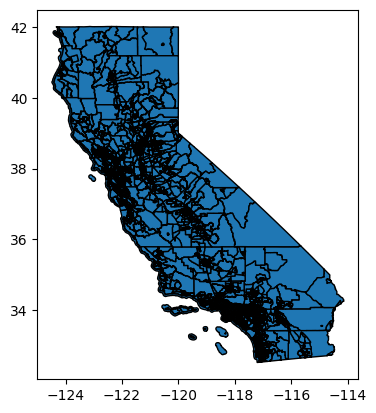

In [ ]:
import os
import geopandas as gpd

arquivos = [os.path.join("/content", f) for f in os.listdir("/content") if f.endswith(".shp")]
arquivo = max(arquivos, key=os.path.getmtime)
tl = gpd.read_file(arquivo).to_crs("EPSG:4326")
tl.plot(edgecolor="black")


In [ ]:
tl[["GEOID","geometry"]] ##TODO: Passar arquivo para HGI (CSV)

## BORO -> GEOID

,GEOID,geometry
0,06085504321,"POLYGON ((-121.87556 37.39924, -121.87535 37.3..."
1,06085504410,"POLYGON ((-121.88886 37.40758, -121.88576 37.4..."
2,06085507003,"POLYGON ((-122.02489 37.21683, -122.02458 37.2..."
3,06085507004,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,06085502204,"POLYGON ((-121.93167 37.29803, -121.92801 37.3..."
...,...,...
9124,06059001303,"POLYGON ((-117.95917 33.92458, -117.95888 33.9..."
9125,06059001304,"POLYGON ((-117.95918 33.9282, -117.95831 33.92..."
9126,06059001401,"POLYGON ((-117.95056 33.94503, -117.95056 33.9..."
9127,06013367200,"POLYGON ((-122.34551 37.96355, -122.3455 37.96..."


In [ ]:
import geopandas as gpd
from shapely import wkt

boroughs = tl[["GEOID", "geometry"]].copy()
boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)

boroughs.to_csv(f"{diretorio_principal}/boroughs_area.csv", index=False)


/tmp/ipython-input-2001046065.py:5: UserWarning: Geometry column does not contain geometry.
  boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)


In [ ]:
boroughs

,GEOID,geometry
0,06085504321,"POLYGON ((-121.875559 37.39924, -121.875352 37..."
1,06085504410,"POLYGON ((-121.888863 37.407575, -121.885763 3..."
2,06085507003,"POLYGON ((-122.024891 37.216828, -122.024585 3..."
3,06085507004,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,06085502204,"POLYGON ((-121.931674 37.29803, -121.928011 37..."
...,...,...
9124,06059001303,"POLYGON ((-117.959174 33.92458, -117.958881 33..."
9125,06059001304,"POLYGON ((-117.959178 33.928202, -117.958306 3..."
9126,06059001401,"POLYGON ((-117.950559 33.945034, -117.950555 3..."
9127,06013367200,"POLYGON ((-122.345508 37.963547, -122.3455 37...."


In [ ]:
!rm -rf /usr/local/lib/python3.12/dist-packages/~orch*
!pip cache purge


Files removed: 14 (3.2 MB)


In [ ]:
%pip -q install -U pip setuptools wheel
%pip -q uninstall -y torch torchvision torchaudio torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib
%pip -q install --no-cache-dir geopandas shapely libpysal h3 h3ronpy pyarrow scipy scikit-learn


In [ ]:
%pip -q install --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cpu
%pip -q install --no-cache-dir pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.4.0+cpu.html


In [ ]:
%cd {diretorio_principal}

/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main


## POI Embedding

In [ ]:
FOLDER_ID_CRUS = "1cV807NNGn4gSDX-7fkJ83rlr0nRo4y89"
FOLDER_ID_SEPARATED = "1XUWhd59YDe8dSrTb6eZlLvhVcLSGpZ7n"

filename = f"checkins_{ESTADO}.csv"

path_crus = f"estados/crus/{filename}"
path_sep  = f"estados/separated/{filename}"

print("Baixando (crus)...")
download_from_folder_by_name(drive_service,FOLDER_ID_CRUS, filename, path_crus)

print("Baixando (separated)...")
download_from_folder_by_name(drive_service,FOLDER_ID_SEPARATED, filename, path_sep)

print("Concluído:", path_crus, "e", path_sep)


Baixando (crus)...
Baixando (separated)...
Concluído: estados/crus/checkins_California.csv e estados/separated/checkins_California.csv


In [ ]:
import pandas as pd, numpy as np, ast
import geopandas as gpd
from shapely.geometry import Point


CHECKIN_NAO_CRU = f"estados/crus/checkins_{ESTADO}.csv"
CHECKIN_CRU     = f"estados/separated/checkins_{ESTADO}.csv"
OUT_POIS        = "pois_gowalla.csv"

df_labeled = pd.read_csv(CHECKIN_NAO_CRU)
df_raw     = pd.read_csv(CHECKIN_CRU)

lon_col_raw = "lng" if "lng" in df_raw.columns else "longitude"
lat_col_raw = "lat" if "lat" in df_raw.columns else "latitude"
lon_col_lab = "lng" if "lng" in df_labeled.columns else ("longitude" if "longitude" in df_labeled.columns else None)
lat_col_lab = "lat" if "lat" in df_labeled.columns else ("latitude" if "latitude" in df_labeled.columns else None)

def parse_names(cell):
    try:
        lst = ast.literal_eval(cell)
        if isinstance(lst, list):
            return [d.get("name") for d in lst if isinstance(d, dict) and "name" in d]
    except Exception:
        pass
    return []

df_raw["__cat_names"] = df_raw["spot_categories"].fillna("[]").apply(parse_names)

def first_or_none(lst):
    return lst[0] if (isinstance(lst, list) and len(lst) > 0) else None

df_raw["__fclass_name"] = df_raw["__cat_names"].apply(first_or_none)

fclass_by_place = (df_raw.dropna(subset=["__fclass_name"])
                          .groupby("placeid")["__fclass_name"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

cat_by_place = (df_labeled.dropna(subset=["category"])
                          .groupby("placeid")["category"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

coords_raw = (df_raw.groupby("placeid")[[lat_col_raw, lon_col_raw]]
                    .mean()
                    .rename(columns={lat_col_raw: "latitude", lon_col_raw: "longitude"}))

if coords_raw.empty and lon_col_lab and lat_col_lab and (lon_col_lab in df_labeled.columns) and (lat_col_lab in df_labeled.columns):
    coords_raw = (df_labeled.groupby("placeid")[[lat_col_lab, lon_col_lab]]
                           .mean()
                           .rename(columns={lat_col_lab: "latitude", lon_col_lab: "longitude"}))

coords_raw = coords_raw.dropna()

pois = pd.DataFrame({"feature_id": coords_raw.index})
pois["feature_id"] = pois["feature_id"].astype(int)

pois["fclass_name"]   = fclass_by_place.reindex(pois["feature_id"]).values
pois["category_name"] = cat_by_place.reindex(pois["feature_id"]).values

pois = pois.dropna(subset=["fclass_name", "category_name"]).reset_index(drop=True)

gdf = gpd.GeoDataFrame(
    pois,
    geometry=gpd.points_from_xy(coords_raw.loc[pois["feature_id"], "longitude"].values,
                                coords_raw.loc[pois["feature_id"], "latitude"].values),
    crs="EPSG:4326"
)
gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)

fclass_vocab = {n:i for i,n in enumerate(pd.Series(gdf["fclass_name"]).dropna().unique())}
cat_vocab    = {n:i for i,n in enumerate(pd.Series(gdf["category_name"]).dropna().unique())}

gdf["fclass"]   = gdf["fclass_name"].map(lambda n: fclass_vocab.get(n, -1)).astype(int)
gdf["category"] = gdf["category_name"].map(lambda n: cat_vocab.get(n, -1)).astype(int)

gdf = gdf[(gdf["fclass"]>=0) & (gdf["category"]>=0)].reset_index(drop=True)

pois_out = gdf[["feature_id", "category", "fclass", "geometry"]].copy()
pois_out.to_csv(OUT_POIS, index=False)



/tmp/ipython-input-2811998353.py:67: UserWarning: Geometry column does not contain geometry.
  gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)


In [ ]:
# @title
import geopandas as gpd
from shapely.geometry import box

lat_min, lat_max = df["latitude"].min(), df["latitude"].max()
lon_min, lon_max = df["longitude"].min(), df["longitude"].max()
area = box(lon_min, lat_min, lon_max, lat_max).buffer(0.01)

boroughs = gpd.GeoDataFrame(geometry=[area], crs="EPSG:4326")

boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)
boroughs.to_csv("boroughs_area.csv", index=False)


In [ ]:
import sys
module_dir = f'{diretorio_principal}/region-embedding/baselines/poi-encoder'

sys.path.insert(0, module_dir)

In [ ]:
from POIEmbedding import PreProcess

PreProcess("pois_gowalla.csv", "boroughs_area.csv", h3=False).run() ##TODO H3 FALSO


boroughs cols: ['GEOID', 'geometry']
        GEOID                                           geometry
0  6085504321  POLYGON ((-121.87556 37.39924, -121.87535 37.3...
1  6085504410  POLYGON ((-121.88886 37.40758, -121.88576 37.4...
2  6085507003  POLYGON ((-122.02489 37.21683, -122.02458 37.2...
3  6085507004  POLYGON ((-121.99304 37.22562, -121.99249 37.2...
4  6085502204  POLYGON ((-121.93167 37.29803, -121.92801 37.3...
           GEOID                                           geometry
0     6085504321  POLYGON ((-121.87556 37.39924, -121.87535 37.3...
1     6085504410  POLYGON ((-121.88886 37.40758, -121.88576 37.4...
2     6085507003  POLYGON ((-122.02489 37.21683, -122.02458 37.2...
3     6085507004  POLYGON ((-121.99304 37.22562, -121.99249 37.2...
4     6085502204  POLYGON ((-121.93167 37.29803, -121.92801 37.3...
...          ...                                                ...
9124  6059001303  POLYGON ((-117.95917 33.92458, -117.95888 33.9...
9125  6059001304  POLYGON ((-

In [ ]:
from POIEmbedding import POI2Vec
p = POI2Vec()
p.train()
p.save_walks()


        source  target    weight
0            0    5307  0.626057
1            0     164  0.651860
2            0    3344  0.585451
3            0  138918  0.612438
4            0  129987  0.620526
...        ...     ...       ...
444913  148253  148255  0.653744
444914  148308  148310  0.654397
444915  148308  148309  0.630476
444916  148309  148310  0.655578
444917  148311  148312  0.750888

[444918 rows x 3 columns]


In [ ]:
from POIEmbedding import POI2Vec
from model import POISet, EmbeddingModel
import torch, torch.utils.data as tud

poi2vec = POI2Vec()
poi2vec.read_walks()
poi2vec.get_global_second_class_walks()

second_class_hierarchy_pairs = list(set([tuple(x) for x in poi2vec.pois[["category","fclass"]].to_numpy()]))
dataset = POISet(
    poi2vec.second_class_number,
    poi2vec.second_class_walks,
    poi2vec.global_second_class_walks,
    k=5
)
model = EmbeddingModel(
    vocab_size=poi2vec.second_class_number,
    embed_size=64,
    second_class_hierarchy_pairs=second_class_hierarchy_pairs,
    le_lambda=1e-8
)

loader = tud.DataLoader(dataset, batch_size=2048, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-2)
for e in range(5):
    for i,(inp,pos,neg) in enumerate(loader):
        opt.zero_grad()
        loss,_ = model(inp.long(), pos.long(), neg.long())
        loss.backward()
        opt.step()

torch.save({"in_embed.weight": model.clone_input_embedding()}, "poi-encoder-gowalla-h3.tensor")


        source  target    weight
0            0    5307  0.626057
1            0     164  0.651860
2            0    3344  0.585451
3            0  138918  0.612438
4            0  129987  0.620526
...        ...     ...       ...
444913  148253  148255  0.653744
444914  148308  148310  0.654397
444915  148308  148309  0.630476
444916  148309  148310  0.655578
444917  148311  148312  0.750888

[444918 rows x 3 columns]


## HGI

In [ ]:
import sys
module_dir = f'{diretorio_principal}/region-embedding/baselines/HGI/preprocess'

sys.path.insert(0, module_dir)

In [ ]:
POIS = "pois_gowalla.csv"
REGS = "boroughs_area.csv"
EMB  = "poi-encoder-gowalla-h3.tensor"

from main import Preprocess
data_dict = Preprocess(POIS, REGS, EMB, h3=False).get_data_torch()

import torch, pickle
from torch_geometric.data import Data

g = Data(
    x=torch.tensor(data_dict['node_features'], dtype=torch.float32),
    edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
    edge_weight=torch.tensor(data_dict['edge_weight'], dtype=torch.float32),
)
g.region_id  = torch.tensor(data_dict['region_id'], dtype=torch.long)
g.region_area = torch.tensor(data_dict['region_area'], dtype=torch.float32)
g.coarse_region_similarity = torch.tensor(data_dict['coarse_region_similarity'], dtype=torch.float32)
g.region_adjacency = torch.tensor(data_dict['region_adjacency'], dtype=torch.long)

torch.save(g, "gowalla.pt")


reading poi data
reading boroughs data


/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 16 disconnected components.
 There are 7 islands with ids: 131, 288, 310, 775, 863, 865, 1065.
  return W(neighbors, **kwargs)


reading boroughs data
creating graph
get region ids
reading embedding
creating region adjacency


/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/preprocess/main.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

creating region similarity by cosine similarity of embeddings
finishing preprocessing


/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 16 disconnected components.
 There are 7 islands with ids: 131, 288, 310, 775, 863, 865, 1065.
  return W(neighbors, **kwargs)


In [ ]:
import os, pickle as pkl, torch
from torch_geometric.data import Data

os.makedirs("./data", exist_ok=True)

g = torch.load("./gowalla.pt", map_location="cpu")

data_dict = {
    "node_features": g.x.detach().cpu().numpy(),
    "edge_index": g.edge_index.detach().cpu().numpy(),
    "edge_weight": g.edge_weight.detach().cpu().numpy(),
    "region_id": g.region_id.detach().cpu().numpy(),
    "region_area": g.region_area.detach().cpu().numpy(),
    "coarse_region_similarity": g.coarse_region_similarity.detach().cpu().numpy(),
    "region_adjacency": g.region_adjacency.detach().cpu().numpy(),
}

with open("./data/gowalla_hgi_data.pkl", "wb") as f:
    pkl.dump(data_dict, f)



/tmp/ipython-input-1595378934.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load("./gowalla.pt", map_location="cpu")


In [ ]:
import numpy as np

R_from_id = int(np.max(data_dict["region_id"])) + 1
R_area    = len(data_dict["region_area"])
R_adj     = int(data_dict["region_adjacency"].max()) + 1
R_sim     = data_dict["coarse_region_similarity"].shape[0]

print("R from id :", R_from_id)
print("R area    :", R_area)
print("R adj     :", R_adj)
print("R sim     :", R_sim)

assert R_from_id == R_area == R_adj == R_sim, "Desalinhad"


R from id : 1072
R area    : 1072
R adj     : 1072
R sim     : 1072


In [ ]:
!python {diretorio_principal}/region-embedding/baselines/HGI/train.py --city gowalla --dim 64 --alpha 0.5 --attention_head 4 --epoch 300 --device cpu --save_name gowalla_h3


Start training region embeddings for the city of gowalla
  0% 0/300 [00:00<?, ?it/s]Parameter containing:
tensor([[ 0.1234, -0.0977,  0.0565,  ..., -0.0098,  0.0997, -0.0469],
        [-0.0819,  0.0133,  0.0604,  ...,  0.0867, -0.0024,  0.0767],
        [-0.0160,  0.0734,  0.0274,  ..., -0.0407,  0.0581,  0.1094],
        ...,
        [-0.0384,  0.0289,  0.0081,  ...,  0.0892,  0.1014, -0.0917],
        [ 0.0105, -0.0858,  0.0184,  ...,  0.0918,  0.0682, -0.0590],
        [ 0.0179, -0.0920,  0.0692,  ..., -0.0179,  0.0965, -0.0882]],
       requires_grad=True) Parameter containing:
tensor([[ 0.0862,  0.1164,  0.1037,  ...,  0.0429,  0.0697,  0.0563],
        [ 0.1082, -0.0978, -0.0370,  ..., -0.0539, -0.0608, -0.0783],
        [-0.0809,  0.0773, -0.0612,  ..., -0.1044,  0.0694,  0.0892],
        ...,
        [ 0.0828,  0.0516,  0.0781,  ..., -0.0906,  0.1187, -0.0582],
        [-0.0515,  0.0034, -0.1073,  ...,  0.0085, -0.0066,  0.0797],
        [ 0.0142,  0.1144, -0.0443,  ...,  0.033

# Montana


Census: https://catalog.data.gov/dataset/tiger-line-shapefile-2021-state-montana-census-tracts

In [ ]:
ESTADO = "Montana"

In [ ]:
diretorio_principal = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/"

In [ ]:
baixar_shapefile_estado("montana")

<Axes: >

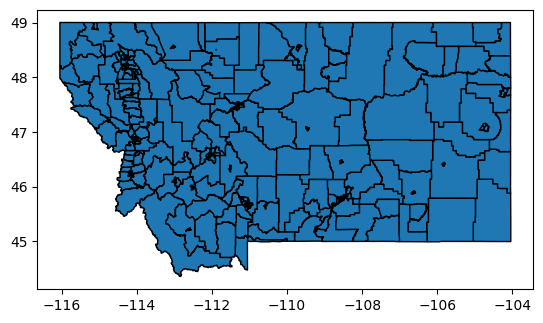

In [ ]:
import os
import geopandas as gpd

arquivos = [os.path.join("/content", f) for f in os.listdir("/content") if f.endswith(".shp")]
arquivo = max(arquivos, key=os.path.getmtime)
tl = gpd.read_file(arquivo).to_crs("EPSG:4326")
tl.plot(edgecolor="black")


In [ ]:
tl[["GEOID","geometry"]] ##TODO: Passar arquivo para HGI (CSV)

## BORO -> GEOID

,GEOID,geometry
0,30111001300,"POLYGON ((-108.60195 45.80163, -108.60192 45.8..."
1,30111001702,"POLYGON ((-108.57625 45.77692, -108.57613 45.7..."
2,30111000704,"POLYGON ((-108.5707 45.82331, -108.57063 45.82..."
3,30111000902,"POLYGON ((-108.52542 45.76976, -108.5245 45.76..."
4,30111000200,"POLYGON ((-108.53398 45.80169, -108.53199 45.8..."
...,...,...
314,30087940400,"POLYGON ((-106.72961 45.40753, -106.72961 45.4..."
315,30087000300,"POLYGON ((-106.69316 45.87987, -106.69258 45.8..."
316,30087000200,"POLYGON ((-107.00756 46.30764, -107.00563 46.3..."
317,30087000100,"POLYGON ((-107.89762 46.8486, -107.89743 46.84..."


In [ ]:
import geopandas as gpd
from shapely import wkt

boroughs = tl[["GEOID", "geometry"]].copy()
boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)

boroughs.to_csv(f"{diretorio_principal}/boroughs_area.csv", index=False)


/tmp/ipython-input-2001046065.py:5: UserWarning: Geometry column does not contain geometry.
  boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)


In [ ]:
boroughs

,GEOID,geometry
0,30111001300,"POLYGON ((-108.601947 45.801632, -108.601919 4..."
1,30111001702,"POLYGON ((-108.576247 45.776925, -108.576126 4..."
2,30111000704,"POLYGON ((-108.570705 45.823311, -108.570632 4..."
3,30111000902,"POLYGON ((-108.525422 45.769761, -108.524497 4..."
4,30111000200,"POLYGON ((-108.53398 45.801689, -108.531994 45..."
...,...,...
314,30087940400,"POLYGON ((-106.729614 45.407528, -106.729612 4..."
315,30087000300,"POLYGON ((-106.693155 45.879866, -106.692576 4..."
316,30087000200,"POLYGON ((-107.007558 46.307645, -107.005634 4..."
317,30087000100,"POLYGON ((-107.897619 46.848602, -107.897429 4..."


In [ ]:
!rm -rf /usr/local/lib/python3.12/dist-packages/~orch*
!pip cache purge


Files removed: 14 (3.2 MB)


In [ ]:
%pip -q install -U pip setuptools wheel
%pip -q uninstall -y torch torchvision torchaudio torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib
%pip -q install --no-cache-dir geopandas shapely libpysal h3 h3ronpy pyarrow scipy scikit-learn


In [ ]:
%pip -q install --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cpu
%pip -q install --no-cache-dir pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.4.0+cpu.html


In [ ]:
%cd {diretorio_principal}

/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main


## POI Embedding

In [ ]:
FOLDER_ID_CRUS = "1cV807NNGn4gSDX-7fkJ83rlr0nRo4y89"
FOLDER_ID_SEPARATED = "1XUWhd59YDe8dSrTb6eZlLvhVcLSGpZ7n"

filename = f"checkins_{ESTADO}.csv"

path_crus = f"estados/crus/{filename}"
path_sep  = f"estados/separated/{filename}"

print("Baixando (crus)...")
download_from_folder_by_name(drive_service,FOLDER_ID_CRUS, filename, path_crus)

print("Baixando (separated)...")
download_from_folder_by_name(drive_service,FOLDER_ID_SEPARATED, filename, path_sep)

print("Concluído:", path_crus, "e", path_sep)


Baixando (crus)...
Baixando (separated)...
Concluído: estados/crus/checkins_Montana.csv e estados/separated/checkins_Montana.csv


In [ ]:
import pandas as pd, numpy as np, ast
import geopandas as gpd
from shapely.geometry import Point


CHECKIN_NAO_CRU = f"estados/crus/checkins_{ESTADO}.csv"
CHECKIN_CRU     = f"estados/separated/checkins_{ESTADO}.csv"
OUT_POIS        = "pois_gowalla.csv"

df_labeled = pd.read_csv(CHECKIN_NAO_CRU)
df_raw     = pd.read_csv(CHECKIN_CRU)

lon_col_raw = "lng" if "lng" in df_raw.columns else "longitude"
lat_col_raw = "lat" if "lat" in df_raw.columns else "latitude"
lon_col_lab = "lng" if "lng" in df_labeled.columns else ("longitude" if "longitude" in df_labeled.columns else None)
lat_col_lab = "lat" if "lat" in df_labeled.columns else ("latitude" if "latitude" in df_labeled.columns else None)

def parse_names(cell):
    try:
        lst = ast.literal_eval(cell)
        if isinstance(lst, list):
            return [d.get("name") for d in lst if isinstance(d, dict) and "name" in d]
    except Exception:
        pass
    return []

df_raw["__cat_names"] = df_raw["spot_categories"].fillna("[]").apply(parse_names)

def first_or_none(lst):
    return lst[0] if (isinstance(lst, list) and len(lst) > 0) else None

df_raw["__fclass_name"] = df_raw["__cat_names"].apply(first_or_none)

fclass_by_place = (df_raw.dropna(subset=["__fclass_name"])
                          .groupby("placeid")["__fclass_name"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

cat_by_place = (df_labeled.dropna(subset=["category"])
                          .groupby("placeid")["category"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

coords_raw = (df_raw.groupby("placeid")[[lat_col_raw, lon_col_raw]]
                    .mean()
                    .rename(columns={lat_col_raw: "latitude", lon_col_raw: "longitude"}))

if coords_raw.empty and lon_col_lab and lat_col_lab and (lon_col_lab in df_labeled.columns) and (lat_col_lab in df_labeled.columns):
    coords_raw = (df_labeled.groupby("placeid")[[lat_col_lab, lon_col_lab]]
                           .mean()
                           .rename(columns={lat_col_lab: "latitude", lon_col_lab: "longitude"}))

coords_raw = coords_raw.dropna()

pois = pd.DataFrame({"feature_id": coords_raw.index})
pois["feature_id"] = pois["feature_id"].astype(int)

pois["fclass_name"]   = fclass_by_place.reindex(pois["feature_id"]).values
pois["category_name"] = cat_by_place.reindex(pois["feature_id"]).values

pois = pois.dropna(subset=["fclass_name", "category_name"]).reset_index(drop=True)

gdf = gpd.GeoDataFrame(
    pois,
    geometry=gpd.points_from_xy(coords_raw.loc[pois["feature_id"], "longitude"].values,
                                coords_raw.loc[pois["feature_id"], "latitude"].values),
    crs="EPSG:4326"
)
gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)

fclass_vocab = {n:i for i,n in enumerate(pd.Series(gdf["fclass_name"]).dropna().unique())}
cat_vocab    = {n:i for i,n in enumerate(pd.Series(gdf["category_name"]).dropna().unique())}

gdf["fclass"]   = gdf["fclass_name"].map(lambda n: fclass_vocab.get(n, -1)).astype(int)
gdf["category"] = gdf["category_name"].map(lambda n: cat_vocab.get(n, -1)).astype(int)

gdf = gdf[(gdf["fclass"]>=0) & (gdf["category"]>=0)].reset_index(drop=True)

pois_out = gdf[["feature_id", "category", "fclass", "geometry"]].copy()
pois_out.to_csv(OUT_POIS, index=False)



/tmp/ipython-input-2811998353.py:67: UserWarning: Geometry column does not contain geometry.
  gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)


In [ ]:
# @title
import geopandas as gpd
from shapely.geometry import box

lat_min, lat_max = df["latitude"].min(), df["latitude"].max()
lon_min, lon_max = df["longitude"].min(), df["longitude"].max()
area = box(lon_min, lat_min, lon_max, lat_max).buffer(0.01)

boroughs = gpd.GeoDataFrame(geometry=[area], crs="EPSG:4326")

boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)
boroughs.to_csv("boroughs_area.csv", index=False)


In [ ]:
import sys
module_dir = f'{diretorio_principal}/region-embedding/baselines/poi-encoder'

sys.path.insert(0, module_dir)

In [ ]:
from POIEmbedding import PreProcess

PreProcess("pois_gowalla.csv", "boroughs_area.csv", h3=False).run() ##TODO H3 FALSO


boroughs cols: ['GEOID', 'geometry']
         GEOID                                           geometry
0  30111001300  POLYGON ((-108.60195 45.80163, -108.60192 45.8...
1  30111001702  POLYGON ((-108.57625 45.77692, -108.57613 45.7...
2  30111000704  POLYGON ((-108.5707 45.82331, -108.57063 45.82...
3  30111000902  POLYGON ((-108.52542 45.76976, -108.5245 45.76...
4  30111000200  POLYGON ((-108.53398 45.80169, -108.53199 45.8...
           GEOID                                           geometry
0    30111001300  POLYGON ((-108.60195 45.80163, -108.60192 45.8...
1    30111001702  POLYGON ((-108.57625 45.77692, -108.57613 45.7...
2    30111000704  POLYGON ((-108.5707 45.82331, -108.57063 45.82...
3    30111000902  POLYGON ((-108.52542 45.76976, -108.5245 45.76...
4    30111000200  POLYGON ((-108.53398 45.80169, -108.53199 45.8...
..           ...                                                ...
314  30087940400  POLYGON ((-106.72961 45.40753, -106.72961 45.4...
315  30087000300  POLYG

In [ ]:
import pandas as pd
import numpy as np
import torch
from shapely import wkt

def build_node_features_from_location_encoder(pois_csv_path: str,
                                              loc_embed_pt_path: str,
                                              placeid_col: str = "feature_id"):

    df_pois = pd.read_csv(pois_csv_path)
    if df_pois["geometry"].dtype == object:
        df_pois["geometry"] = df_pois["geometry"].apply(wkt.loads)

    blob = torch.load(loc_embed_pt_path, map_location="cpu")
    E = blob["embeddings"].detach().cpu().numpy()
    placeids = [str(p) for p in blob["placeids"]]
    placeid2idx = {pid: i for i, pid in enumerate(placeids)}

    ids = df_pois[placeid_col].astype(str).tolist()
    D = E.shape[1]
    X = np.zeros((len(ids), D), dtype=np.float32)

    for i, pid in enumerate(ids):
        idx = placeid2idx.get(pid)
        if idx is None:
            raise KeyError(f"placeid {pid} não encontrado em {loc_embed_pt_path}. "
                           f"")
        X[i] = E[idx]

    return X, df_pois


In [ ]:
# @title
from POIEmbedding import POI2Vec
p = POI2Vec()
p.train()
p.save_walks()


      source  target    weight
0          0    1149  0.448649
1          0      96  0.487299
2          0     804  0.491369
3          0     814  0.505366
4          0     906  0.486308
...      ...     ...       ...
3648    1211    1216  0.371429
3649    1211    1212  0.498321
3650    1212    1213  0.779403
3651    1212    1214  0.515824
3652    1213    1214  0.516458

[3653 rows x 3 columns]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# @title
from POIEmbedding import POI2Vec
from model import POISet, EmbeddingModel
import torch, torch.utils.data as tud

poi2vec = POI2Vec()
poi2vec.read_walks()
poi2vec.get_global_second_class_walks()

second_class_hierarchy_pairs = list(set([tuple(x) for x in poi2vec.pois[["category","fclass"]].to_numpy()]))
dataset = POISet(
    poi2vec.second_class_number,
    poi2vec.second_class_walks,
    poi2vec.global_second_class_walks,
    k=5
)
model = EmbeddingModel(
    vocab_size=poi2vec.second_class_number,
    embed_size=64,
    second_class_hierarchy_pairs=second_class_hierarchy_pairs,
    le_lambda=1e-8
)

loader = tud.DataLoader(dataset, batch_size=2048, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-2)
for e in range(5):
    for i,(inp,pos,neg) in enumerate(loader):
        opt.zero_grad()
        loss,_ = model(inp.long(), pos.long(), neg.long())
        loss.backward()
        opt.step()

torch.save({"in_embed.weight": model.clone_input_embedding()}, "poi-encoder-gowalla-h3.tensor")


      source  target    weight
0          0    1149  0.448649
1          0      96  0.487299
2          0     804  0.491369
3          0     814  0.505366
4          0     906  0.486308
...      ...     ...       ...
3648    1211    1216  0.371429
3649    1211    1212  0.498321
3650    1212    1213  0.779403
3651    1212    1214  0.515824
3652    1213    1214  0.516458

[3653 rows x 3 columns]


## HGI

In [ ]:
import sys
module_dir = f'{diretorio_principal}/region-embedding/baselines/HGI/preprocess'

sys.path.insert(0, module_dir)

In [ ]:
import torch, numpy as np, pandas as pd
from torch_geometric.data import Data
from main import Preprocess

POIS = "pois_gowalla.csv"
REGS = "boroughs_area.csv"

data_dict = Preprocess(POIS, REGS, emb_filename=None, h3=False).get_data_torch()

loc_pt_path = "/content/poi_embeddings_location.pt"
blob = torch.load(loc_pt_path, map_location="cpu")
E = blob["embeddings"].detach().cpu().numpy()
placeids = [str(p) for p in blob["placeids"]]
placeid2idx = {pid: i for i, pid in enumerate(placeids)}
D = E.shape[1]

order = pd.read_csv("poi_index.csv")
order["feature_id"] = order["feature_id"].astype(str)

X = np.zeros((len(order), D), dtype=np.float32)
for i, pid in enumerate(order["feature_id"].tolist()):
    idx = placeid2idx.get(pid)
    if idx is None:
        raise KeyError(f"placeid {pid} não encontrado em {loc_pt_path}. Gere embeddings para todos os POIs.")
    X[i] = E[idx]

import numpy as np
ei = np.asarray(data_dict['edge_index'])
assert ei.max() < X.shape[0], "edge_index referencia nó >= len(X) — ordem quebrou"

g = Data(
    x=torch.tensor(X, dtype=torch.float32),
    edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
    edge_weight=torch.tensor(data_dict['edge_weight'], dtype=torch.float32),
)
g.region_id  = torch.tensor(data_dict['region_id'], dtype=torch.long)
g.region_area = torch.tensor(data_dict['region_area'], dtype=torch.float32)
g.coarse_region_similarity = torch.tensor(data_dict['coarse_region_similarity'], dtype=torch.float32)
g.region_adjacency = torch.tensor(data_dict['region_adjacency'], dtype=torch.long)

torch.save(g, "gowalla.pt")


reading poi data
reading boroughs data
reading boroughs data
creating graph
get region ids
reading embedding
creating region adjacency
creating region similarity by cosine similarity of embeddings
finishing preprocessing


/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 14 disconnected components.
 There are 6 islands with ids: 31, 86, 109, 142, 178, 180.
  return W(neighbors, **kwargs)
/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 14 disconnected components.
 There are 6 islands with ids: 31, 86, 109, 142, 178, 180.
  return W(neighbors, **kwargs)
/tmp/ipython-input-3600412424.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the 

In [ ]:
import os, pickle as pkl, torch
from torch_geometric.data import Data

os.makedirs("./data", exist_ok=True)

g = torch.load("./gowalla.pt", map_location="cpu")

data_dict = {
    "node_features": g.x.detach().cpu().numpy(),
    "edge_index": g.edge_index.detach().cpu().numpy(),
    "edge_weight": g.edge_weight.detach().cpu().numpy(),
    "region_id": g.region_id.detach().cpu().numpy(),
    "region_area": g.region_area.detach().cpu().numpy(),
    "coarse_region_similarity": g.coarse_region_similarity.detach().cpu().numpy(),
    "region_adjacency": g.region_adjacency.detach().cpu().numpy(),
}

with open("./data/gowalla_hgi_data.pkl", "wb") as f:
    pkl.dump(data_dict, f)



/tmp/ipython-input-1595378934.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load("./gowalla.pt", map_location="cpu")


In [ ]:
import numpy as np

R_from_id = int(np.max(data_dict["region_id"])) + 1
R_area    = len(data_dict["region_area"])
R_adj     = int(data_dict["region_adjacency"].max()) + 1
R_sim     = data_dict["coarse_region_similarity"].shape[0]

print("R from id :", R_from_id)
print("R area    :", R_area)
print("R adj     :", R_adj)
print("R sim     :", R_sim)

assert R_from_id == R_area == R_adj == R_sim, "Desalinhad"


R from id : 208
R area    : 208
R adj     : 208
R sim     : 208


In [ ]:
!python {diretorio_principal}/region-embedding/baselines/HGI/train.py --city gowalla --dim 64 --alpha 0.5 --attention_head 4 --epoch 300 --device cpu --save_name gowalla_h3


Streaming output truncated to the last 5000 lines.
        [-0.1305,  0.0989, -0.0275,  ...,  0.0690,  0.0412, -0.0558]],
       requires_grad=True)
0.9703390598297119
 53% 159/300 [01:26<01:19,  1.76it/s, loss=0.9703]Parameter containing:
tensor([[-0.0651, -0.1831, -0.1429,  ...,  0.0399,  0.1042,  0.1159],
        [ 0.1606, -0.0948, -0.1000,  ...,  0.0566,  0.0257,  0.1077],
        [-0.0070,  0.0387,  0.0616,  ..., -0.1475,  0.0681, -0.0596],
        ...,
        [-0.0290, -0.1934, -0.1399,  ..., -0.1374, -0.0998,  0.0446],
        [-0.0679, -0.0144, -0.1435,  ...,  0.1108, -0.0457,  0.0087],
        [-0.0829, -0.1323, -0.0925,  ..., -0.1178, -0.0385,  0.1055]],
       requires_grad=True) Parameter containing:
tensor([[-0.0343, -0.0371, -0.0090,  ...,  0.0376,  0.0799, -0.0648],
        [-0.0551, -0.1066,  0.0844,  ...,  0.0240, -0.0225, -0.0906],
        [ 0.1297, -0.0610,  0.0556,  ...,  0.1106, -0.0730, -0.0217],
        ...,
        [ 0.0440, -0.0726, -0.1112,  ...,  0.0168,  0.

# Nebraska


Census: https://catalog.data.gov/dataset/tiger-line-shapefile-2021-state-nebraska-census-tracts

In [ ]:
ESTADO = "Nebraska"

In [ ]:
diretorio_principal = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/"

In [ ]:
baixar_shapefile_estado("nebraska")

<Axes: >

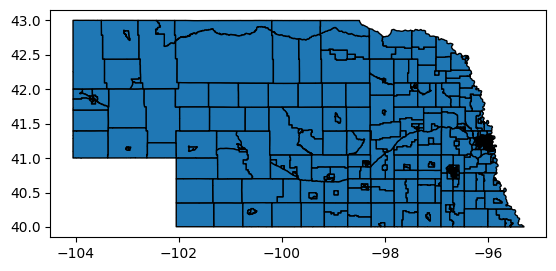

In [ ]:
import os
import geopandas as gpd

arquivos = [os.path.join("/content", f) for f in os.listdir("/content") if f.endswith(".shp")]
arquivo = max(arquivos, key=os.path.getmtime)
tl = gpd.read_file(arquivo).to_crs("EPSG:4326")
tl.plot(edgecolor="black")


In [ ]:
tl[["GEOID","geometry"]] ##TODO: Passar arquivo para HGI (CSV)

## BORO -> GEOID

,GEOID,geometry
0,31137967000,"POLYGON ((-99.42555 40.40799, -99.42522 40.408..."
1,31137967200,"POLYGON ((-99.64441 40.5163, -99.64441 40.5173..."
2,31137967100,"POLYGON ((-99.47431 40.496, -99.47384 40.496, ..."
3,31139979200,"POLYGON ((-97.83498 42.2488, -97.83498 42.2492..."
4,31139979100,"POLYGON ((-97.56289 42.17675, -97.56281 42.177..."
...,...,...
548,31029961900,"POLYGON ((-102.0518 40.36007, -102.05156 40.37..."
549,31153010503,"POLYGON ((-96.00926 41.1907, -96.00913 41.1907..."
550,31183973600,"POLYGON ((-98.76118 42.07117, -98.76116 42.072..."
551,31055007442,"POLYGON ((-96.15807 41.27397, -96.15807 41.274..."


In [ ]:
import geopandas as gpd
from shapely import wkt

boroughs = tl[["GEOID", "geometry"]].copy()
boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)

boroughs.to_csv(f"{diretorio_principal}/boroughs_area.csv", index=False)


/tmp/ipython-input-2001046065.py:5: UserWarning: Geometry column does not contain geometry.
  boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)


In [ ]:
boroughs

,GEOID,geometry
0,31137967000,"POLYGON ((-99.425549 40.407986, -99.42522 40.4..."
1,31137967200,"POLYGON ((-99.644407 40.516296, -99.644406 40...."
2,31137967100,"POLYGON ((-99.474313 40.496, -99.473837 40.495..."
3,31139979200,"POLYGON ((-97.834977 42.248801, -97.834983 42...."
4,31139979100,"POLYGON ((-97.56289 42.176754, -97.562806 42.1..."
...,...,...
548,31029961900,"POLYGON ((-102.051798 40.360069, -102.051555 4..."
549,31153010503,"POLYGON ((-96.009261 41.190702, -96.009134 41...."
550,31183973600,"POLYGON ((-98.761183 42.071172, -98.761164 42...."
551,31055007442,"POLYGON ((-96.158074 41.273971, -96.158074 41...."


In [ ]:
!rm -rf /usr/local/lib/python3.12/dist-packages/~orch*
!pip cache purge


Files removed: 6 (250 kB)


In [ ]:
%pip -q install -U pip setuptools wheel
%pip -q uninstall -y torch torchvision torchaudio torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib
%pip -q install --no-cache-dir geopandas shapely libpysal h3 h3ronpy pyarrow scipy scikit-learn


In [ ]:
%pip -q install --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cpu
%pip -q install --no-cache-dir pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.4.0+cpu.html


In [ ]:
%cd {diretorio_principal}

/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main


## POI Embedding

In [ ]:
FOLDER_ID_CRUS = "1cV807NNGn4gSDX-7fkJ83rlr0nRo4y89"
FOLDER_ID_SEPARATED = "1XUWhd59YDe8dSrTb6eZlLvhVcLSGpZ7n"

filename = f"checkins_{ESTADO}.csv"

path_crus = f"estados/crus/{filename}"
path_sep  = f"estados/separated/{filename}"

print("Baixando (crus)...")
download_from_folder_by_name(drive_service,FOLDER_ID_CRUS, filename, path_crus)

print("Baixando (separated)...")
download_from_folder_by_name(drive_service,FOLDER_ID_SEPARATED, filename, path_sep)

print("Concluído:", path_crus, "e", path_sep)


Baixando (crus)...
Baixando (separated)...
Concluído: estados/crus/checkins_Nebraska.csv e estados/separated/checkins_Nebraska.csv


In [ ]:
import pandas as pd, numpy as np, ast
import geopandas as gpd
from shapely.geometry import Point


CHECKIN_NAO_CRU = f"estados/crus/checkins_{ESTADO}.csv"
CHECKIN_CRU     = f"estados/separated/checkins_{ESTADO}.csv"
OUT_POIS        = "pois_gowalla.csv"

df_labeled = pd.read_csv(CHECKIN_NAO_CRU)
df_raw     = pd.read_csv(CHECKIN_CRU)

lon_col_raw = "lng" if "lng" in df_raw.columns else "longitude"
lat_col_raw = "lat" if "lat" in df_raw.columns else "latitude"
lon_col_lab = "lng" if "lng" in df_labeled.columns else ("longitude" if "longitude" in df_labeled.columns else None)
lat_col_lab = "lat" if "lat" in df_labeled.columns else ("latitude" if "latitude" in df_labeled.columns else None)

def parse_names(cell):
    try:
        lst = ast.literal_eval(cell)
        if isinstance(lst, list):
            return [d.get("name") for d in lst if isinstance(d, dict) and "name" in d]
    except Exception:
        pass
    return []

df_raw["__cat_names"] = df_raw["spot_categories"].fillna("[]").apply(parse_names)

def first_or_none(lst):
    return lst[0] if (isinstance(lst, list) and len(lst) > 0) else None

df_raw["__fclass_name"] = df_raw["__cat_names"].apply(first_or_none)

fclass_by_place = (df_raw.dropna(subset=["__fclass_name"])
                          .groupby("placeid")["__fclass_name"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

cat_by_place = (df_labeled.dropna(subset=["category"])
                          .groupby("placeid")["category"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

coords_raw = (df_raw.groupby("placeid")[[lat_col_raw, lon_col_raw]]
                    .mean()
                    .rename(columns={lat_col_raw: "latitude", lon_col_raw: "longitude"}))

if coords_raw.empty and lon_col_lab and lat_col_lab and (lon_col_lab in df_labeled.columns) and (lat_col_lab in df_labeled.columns):
    coords_raw = (df_labeled.groupby("placeid")[[lat_col_lab, lon_col_lab]]
                           .mean()
                           .rename(columns={lat_col_lab: "latitude", lon_col_lab: "longitude"}))

coords_raw = coords_raw.dropna()

pois = pd.DataFrame({"feature_id": coords_raw.index})
pois["feature_id"] = pois["feature_id"].astype(int)

pois["fclass_name"]   = fclass_by_place.reindex(pois["feature_id"]).values
pois["category_name"] = cat_by_place.reindex(pois["feature_id"]).values

pois = pois.dropna(subset=["fclass_name", "category_name"]).reset_index(drop=True)

gdf = gpd.GeoDataFrame(
    pois,
    geometry=gpd.points_from_xy(coords_raw.loc[pois["feature_id"], "longitude"].values,
                                coords_raw.loc[pois["feature_id"], "latitude"].values),
    crs="EPSG:4326"
)
gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)

fclass_vocab = {n:i for i,n in enumerate(pd.Series(gdf["fclass_name"]).dropna().unique())}
cat_vocab    = {n:i for i,n in enumerate(pd.Series(gdf["category_name"]).dropna().unique())}

gdf["fclass"]   = gdf["fclass_name"].map(lambda n: fclass_vocab.get(n, -1)).astype(int)
gdf["category"] = gdf["category_name"].map(lambda n: cat_vocab.get(n, -1)).astype(int)

gdf = gdf[(gdf["fclass"]>=0) & (gdf["category"]>=0)].reset_index(drop=True)

pois_out = gdf[["feature_id", "category", "fclass", "geometry"]].copy()
pois_out.to_csv(OUT_POIS, index=False)



/tmp/ipython-input-2811998353.py:67: UserWarning: Geometry column does not contain geometry.
  gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)


In [ ]:
# @title
import geopandas as gpd
from shapely.geometry import box

lat_min, lat_max = df["latitude"].min(), df["latitude"].max()
lon_min, lon_max = df["longitude"].min(), df["longitude"].max()
area = box(lon_min, lat_min, lon_max, lat_max).buffer(0.01)

boroughs = gpd.GeoDataFrame(geometry=[area], crs="EPSG:4326")

boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)
boroughs.to_csv("boroughs_area.csv", index=False)


In [ ]:
import sys
module_dir = f'{diretorio_principal}/region-embedding/baselines/poi-encoder'

sys.path.insert(0, module_dir)

In [ ]:
from POIEmbedding import PreProcess

PreProcess("pois_gowalla.csv", "boroughs_area.csv", h3=False).run() ##TODO H3 FALSO


boroughs cols: ['GEOID', 'geometry']
         GEOID                                           geometry
0  31137967000  POLYGON ((-99.42555 40.40799, -99.42522 40.408...
1  31137967200  POLYGON ((-99.64441 40.5163, -99.64441 40.5173...
2  31137967100  POLYGON ((-99.47431 40.496, -99.47384 40.496, ...
3  31139979200  POLYGON ((-97.83498 42.2488, -97.83498 42.2492...
4  31139979100  POLYGON ((-97.56289 42.17675, -97.56281 42.177...
           GEOID                                           geometry
0    31137967000  POLYGON ((-99.42555 40.40799, -99.42522 40.408...
1    31137967200  POLYGON ((-99.64441 40.5163, -99.64441 40.5173...
2    31137967100  POLYGON ((-99.47431 40.496, -99.47384 40.496, ...
3    31139979200  POLYGON ((-97.83498 42.2488, -97.83498 42.2492...
4    31139979100  POLYGON ((-97.56289 42.17675, -97.56281 42.177...
..           ...                                                ...
548  31029961900  POLYGON ((-102.0518 40.36007, -102.05156 40.37...
549  31153010503  POLYG

In [ ]:
import pandas as pd
import numpy as np
import torch
from shapely import wkt

def build_node_features_from_location_encoder(pois_csv_path: str,
                                              loc_embed_pt_path: str,
                                              placeid_col: str = "feature_id"):

    df_pois = pd.read_csv(pois_csv_path)
    if df_pois["geometry"].dtype == object:
        df_pois["geometry"] = df_pois["geometry"].apply(wkt.loads)

    blob = torch.load(loc_embed_pt_path, map_location="cpu")
    E = blob["embeddings"].detach().cpu().numpy()
    placeids = [str(p) for p in blob["placeids"]]
    placeid2idx = {pid: i for i, pid in enumerate(placeids)}

    ids = df_pois[placeid_col].astype(str).tolist()
    D = E.shape[1]
    X = np.zeros((len(ids), D), dtype=np.float32)

    for i, pid in enumerate(ids):
        idx = placeid2idx.get(pid)
        if idx is None:
            raise KeyError(f"placeid {pid} não encontrado em {loc_embed_pt_path}. "
                           f"")
        X[i] = E[idx]

    return X, df_pois


In [ ]:
# @title
from POIEmbedding import POI2Vec
p = POI2Vec()
p.train()
p.save_walks()


      source  target    weight
0          0    1340  0.498964
1          0     639  0.412093
2          0    2793  0.503600
3          0    2537  0.729299
4          1    2743  0.525857
...      ...     ...       ...
8448    2816    2817  0.629293
8449    2816    2818  0.652857
8450    2817    2819  0.501285
8451    2817    2818  0.747688
8452    2818    2819  0.507854

[8453 rows x 3 columns]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# @title
from POIEmbedding import POI2Vec
from model import POISet, EmbeddingModel
import torch, torch.utils.data as tud

poi2vec = POI2Vec()
poi2vec.read_walks()
poi2vec.get_global_second_class_walks()

second_class_hierarchy_pairs = list(set([tuple(x) for x in poi2vec.pois[["category","fclass"]].to_numpy()]))
dataset = POISet(
    poi2vec.second_class_number,
    poi2vec.second_class_walks,
    poi2vec.global_second_class_walks,
    k=5
)
model = EmbeddingModel(
    vocab_size=poi2vec.second_class_number,
    embed_size=64,
    second_class_hierarchy_pairs=second_class_hierarchy_pairs,
    le_lambda=1e-8
)

loader = tud.DataLoader(dataset, batch_size=2048, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-2)
for e in range(5):
    for i,(inp,pos,neg) in enumerate(loader):
        opt.zero_grad()
        loss,_ = model(inp.long(), pos.long(), neg.long())
        loss.backward()
        opt.step()

torch.save({"in_embed.weight": model.clone_input_embedding()}, "poi-encoder-gowalla-h3.tensor")


      source  target    weight
0          0    1340  0.498964
1          0     639  0.412093
2          0    2793  0.503600
3          0    2537  0.729299
4          1    2743  0.525857
...      ...     ...       ...
8448    2816    2817  0.629293
8449    2816    2818  0.652857
8450    2817    2819  0.501285
8451    2817    2818  0.747688
8452    2818    2819  0.507854

[8453 rows x 3 columns]


## HGI

In [ ]:
import sys
module_dir = f'{diretorio_principal}/region-embedding/baselines/HGI/preprocess'

sys.path.insert(0, module_dir)

In [ ]:
import torch, numpy as np, pandas as pd
from torch_geometric.data import Data
from main import Preprocess

POIS = "pois_gowalla.csv"
REGS = "boroughs_area.csv"

data_dict = Preprocess(POIS, REGS, emb_filename=None, h3=False).get_data_torch()

loc_pt_path = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/poi_embeddings_location.pt"
blob = torch.load(loc_pt_path, map_location="cpu")
E = blob["embeddings"].detach().cpu().numpy()
placeids = [str(p) for p in blob["placeids"]]
placeid2idx = {pid: i for i, pid in enumerate(placeids)}
D = E.shape[1]

order = pd.read_csv("poi_index.csv")
order["feature_id"] = order["feature_id"].astype(str)

X = np.zeros((len(order), D), dtype=np.float32)
for i, pid in enumerate(order["feature_id"].tolist()):
    idx = placeid2idx.get(pid)
    if idx is None:
        raise KeyError(f"placeid {pid} não encontrado em {loc_pt_path}. Gere embeddings para todos os POIs.")
    X[i] = E[idx]

import numpy as np
ei = np.asarray(data_dict['edge_index'])
assert ei.max() < X.shape[0], "edge_index referencia nó >= len(X) — ordem quebrou"

g = Data(
    x=torch.tensor(X, dtype=torch.float32),
    edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
    edge_weight=torch.tensor(data_dict['edge_weight'], dtype=torch.float32),
)
g.region_id  = torch.tensor(data_dict['region_id'], dtype=torch.long)
g.region_area = torch.tensor(data_dict['region_area'], dtype=torch.float32)
g.coarse_region_similarity = torch.tensor(data_dict['coarse_region_similarity'], dtype=torch.float32)
g.region_adjacency = torch.tensor(data_dict['region_adjacency'], dtype=torch.long)

torch.save(g, "gowalla.pt")


reading poi data
reading boroughs data


/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 19 disconnected components.
 There are 9 islands with ids: 10, 44, 47, 223, 339, 340, 404, 407, 410.
  return W(neighbors, **kwargs)
/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 19 disconnected components.
 There are 9 islands with ids: 10, 44, 47, 223, 339, 340, 404, 407, 410.
  return W(neighbors, **kwargs)
/tmp/ipython-input-2460681102.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped

reading boroughs data
creating graph
get region ids
reading embedding
creating region adjacency
creating region similarity by cosine similarity of embeddings
finishing preprocessing


In [ ]:
import os, pickle as pkl, torch
from torch_geometric.data import Data

os.makedirs("./data", exist_ok=True)

g = torch.load("./gowalla.pt", map_location="cpu")

data_dict = {
    "node_features": g.x.detach().cpu().numpy(),
    "edge_index": g.edge_index.detach().cpu().numpy(),
    "edge_weight": g.edge_weight.detach().cpu().numpy(),
    "region_id": g.region_id.detach().cpu().numpy(),
    "region_area": g.region_area.detach().cpu().numpy(),
    "coarse_region_similarity": g.coarse_region_similarity.detach().cpu().numpy(),
    "region_adjacency": g.region_adjacency.detach().cpu().numpy(),
}

with open("./data/gowalla_hgi_data.pkl", "wb") as f:
    pkl.dump(data_dict, f)



/tmp/ipython-input-1595378934.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load("./gowalla.pt", map_location="cpu")


In [ ]:
import numpy as np

R_from_id = int(np.max(data_dict["region_id"])) + 1
R_area    = len(data_dict["region_area"])
R_adj     = int(data_dict["region_adjacency"].max()) + 1
R_sim     = data_dict["coarse_region_similarity"].shape[0]

print("R from id :", R_from_id)
print("R area    :", R_area)
print("R adj     :", R_adj)
print("R sim     :", R_sim)

assert R_from_id == R_area == R_adj == R_sim, "Desalinhad"


R from id : 415
R area    : 415
R adj     : 415
R sim     : 415


In [ ]:
!python {diretorio_principal}/region-embedding/baselines/HGI/train.py --city gowalla --dim 64 --alpha 0.5 --attention_head 4 --epoch 300 --device cpu --save_name gowalla_h3


Streaming output truncated to the last 5000 lines.
        [-0.1656,  0.0533, -0.0382,  ..., -0.0689, -0.0063, -0.0058]],
       requires_grad=True) Parameter containing:
tensor([[ 0.0789, -0.0211,  0.0419,  ..., -0.1202,  0.0974,  0.0237],
        [-0.0341, -0.0142,  0.0765,  ..., -0.1038, -0.0470, -0.0857],
        [-0.0915, -0.0380, -0.0681,  ...,  0.0509, -0.0794,  0.0784],
        ...,
        [ 0.0639, -0.0683,  0.0689,  ...,  0.1035,  0.1118,  0.0351],
        [-0.0801, -0.0512,  0.1104,  ..., -0.0361,  0.0791,  0.0926],
        [-0.0703,  0.0074,  0.0702,  ...,  0.0917,  0.0633, -0.0426]],
       requires_grad=True)
Parameter containing:
tensor([[-0.0478,  0.0514, -0.0833,  ...,  0.0202, -0.0096, -0.1220],
        [ 0.0646, -0.0282,  0.0291,  ..., -0.0354, -0.0370, -0.0099],
        [-0.0110,  0.1517,  0.0844,  ...,  0.1119,  0.0903, -0.0946],
        ...,
        [ 0.0107, -0.0427,  0.1069,  ...,  0.1078,  0.1346, -0.1231],
        [-0.0484,  0.0367, -0.0406,  ...,  0.0890, -0

# Florida


Census: https://catalog.data.gov/dataset/tiger-line-shapefile-2021-state-florida-census-tracts

In [ ]:
ESTADO = "Florida"

In [ ]:
diretorio_principal = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/"

In [ ]:
baixar_shapefile_estado("florida")

<Axes: >

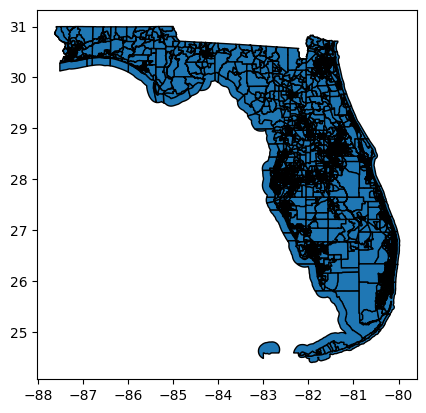

In [ ]:
import os
import geopandas as gpd

arquivos = [os.path.join("/content", f) for f in os.listdir("/content") if f.endswith(".shp")]
arquivo = max(arquivos, key=os.path.getmtime)
tl = gpd.read_file(arquivo).to_crs("EPSG:4326")
tl.plot(edgecolor="black")


In [ ]:
tl[["GEOID","geometry"]] ##TODO: Passar arquivo para HGI (CSV)

## BORO -> GEOID

,GEOID,geometry
0,12127080600,"POLYGON ((-81.07344 29.29253, -81.07342 29.292..."
1,12127082406,"POLYGON ((-81.01981 29.15447, -81.01972 29.154..."
2,12127081300,"POLYGON ((-81.01538 29.21656, -81.0151 29.2170..."
3,12127081500,"POLYGON ((-81.03353 29.22556, -81.03318 29.225..."
4,12127081600,"POLYGON ((-81.0493 29.22346, -81.04926 29.2234..."
...,...,...
5155,12103028103,"POLYGON ((-82.7461 27.74625, -82.74606 27.7463..."
5156,12103028104,"POLYGON ((-82.75336 27.75266, -82.75275 27.753..."
5157,12103024408,"POLYGON ((-82.63872 27.8428, -82.63812 27.8428..."
5158,12086000710,"POLYGON ((-80.31436 25.84797, -80.31305 25.847..."


In [ ]:
import geopandas as gpd
from shapely import wkt

boroughs = tl[["GEOID", "geometry"]].copy()
boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)

boroughs.to_csv(f"{diretorio_principal}/boroughs_area.csv", index=False)


/tmp/ipython-input-2001046065.py:5: UserWarning: Geometry column does not contain geometry.
  boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)


In [ ]:
boroughs

,GEOID,geometry
0,12127080600,"POLYGON ((-81.07344 29.292531, -81.073425 29.2..."
1,12127082406,"POLYGON ((-81.019806 29.154466, -81.019725 29...."
2,12127081300,"POLYGON ((-81.015384 29.216565, -81.0151 29.21..."
3,12127081500,"POLYGON ((-81.033528 29.225562, -81.033181 29...."
4,12127081600,"POLYGON ((-81.049303 29.223465, -81.049256 29...."
...,...,...
5155,12103028103,"POLYGON ((-82.746096 27.746247, -82.746065 27...."
5156,12103028104,"POLYGON ((-82.753359 27.75266, -82.752747 27.7..."
5157,12103024408,"POLYGON ((-82.638724 27.842795, -82.638117 27...."
5158,12086000710,"POLYGON ((-80.314363 25.84797, -80.313053 25.8..."


In [ ]:
!rm -rf /usr/local/lib/python3.12/dist-packages/~orch*
!pip cache purge


Files removed: 0


In [ ]:
%pip -q install -U pip setuptools wheel
%pip -q uninstall -y torch torchvision torchaudio torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib
%pip -q install --no-cache-dir geopandas shapely libpysal h3 h3ronpy pyarrow scipy scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 85.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
%pip -q install --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cpu
%pip -q install --no-cache-dir pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.4.0+cpu.html


In [ ]:
%cd {diretorio_principal}

/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main


## POI Embedding

In [ ]:
FOLDER_ID_CRUS = "1cV807NNGn4gSDX-7fkJ83rlr0nRo4y89"
FOLDER_ID_SEPARATED = "1XUWhd59YDe8dSrTb6eZlLvhVcLSGpZ7n"

filename = f"checkins_{ESTADO}.csv"

path_crus = f"estados/crus/{filename}"
path_sep  = f"estados/separated/{filename}"

print("Baixando (crus)...")
download_from_folder_by_name(drive_service,FOLDER_ID_CRUS, filename, path_crus)

print("Baixando (separated)...")
download_from_folder_by_name(drive_service,FOLDER_ID_SEPARATED, filename, path_sep)

print("Concluído:", path_crus, "e", path_sep)


Baixando (crus)...
Baixando (separated)...
Concluído: estados/crus/checkins_Florida.csv e estados/separated/checkins_Florida.csv


In [ ]:
import pandas as pd, numpy as np, ast
import geopandas as gpd
from shapely.geometry import Point


CHECKIN_NAO_CRU = f"estados/crus/checkins_{ESTADO}.csv"
CHECKIN_CRU     = f"estados/separated/checkins_{ESTADO}.csv"
OUT_POIS        = "pois_gowalla.csv"

df_labeled = pd.read_csv(CHECKIN_NAO_CRU)
df_raw     = pd.read_csv(CHECKIN_CRU)

lon_col_raw = "lng" if "lng" in df_raw.columns else "longitude"
lat_col_raw = "lat" if "lat" in df_raw.columns else "latitude"
lon_col_lab = "lng" if "lng" in df_labeled.columns else ("longitude" if "longitude" in df_labeled.columns else None)
lat_col_lab = "lat" if "lat" in df_labeled.columns else ("latitude" if "latitude" in df_labeled.columns else None)

def parse_names(cell):
    try:
        lst = ast.literal_eval(cell)
        if isinstance(lst, list):
            return [d.get("name") for d in lst if isinstance(d, dict) and "name" in d]
    except Exception:
        pass
    return []

df_raw["__cat_names"] = df_raw["spot_categories"].fillna("[]").apply(parse_names)

def first_or_none(lst):
    return lst[0] if (isinstance(lst, list) and len(lst) > 0) else None

df_raw["__fclass_name"] = df_raw["__cat_names"].apply(first_or_none)

fclass_by_place = (df_raw.dropna(subset=["__fclass_name"])
                          .groupby("placeid")["__fclass_name"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

cat_by_place = (df_labeled.dropna(subset=["category"])
                          .groupby("placeid")["category"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

coords_raw = (df_raw.groupby("placeid")[[lat_col_raw, lon_col_raw]]
                    .mean()
                    .rename(columns={lat_col_raw: "latitude", lon_col_raw: "longitude"}))

if coords_raw.empty and lon_col_lab and lat_col_lab and (lon_col_lab in df_labeled.columns) and (lat_col_lab in df_labeled.columns):
    coords_raw = (df_labeled.groupby("placeid")[[lat_col_lab, lon_col_lab]]
                           .mean()
                           .rename(columns={lat_col_lab: "latitude", lon_col_lab: "longitude"}))

coords_raw = coords_raw.dropna()

pois = pd.DataFrame({"feature_id": coords_raw.index})
pois["feature_id"] = pois["feature_id"].astype(int)

pois["fclass_name"]   = fclass_by_place.reindex(pois["feature_id"]).values
pois["category_name"] = cat_by_place.reindex(pois["feature_id"]).values

pois = pois.dropna(subset=["fclass_name", "category_name"]).reset_index(drop=True)

gdf = gpd.GeoDataFrame(
    pois,
    geometry=gpd.points_from_xy(coords_raw.loc[pois["feature_id"], "longitude"].values,
                                coords_raw.loc[pois["feature_id"], "latitude"].values),
    crs="EPSG:4326"
)
gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)

fclass_vocab = {n:i for i,n in enumerate(pd.Series(gdf["fclass_name"]).dropna().unique())}
cat_vocab    = {n:i for i,n in enumerate(pd.Series(gdf["category_name"]).dropna().unique())}

gdf["fclass"]   = gdf["fclass_name"].map(lambda n: fclass_vocab.get(n, -1)).astype(int)
gdf["category"] = gdf["category_name"].map(lambda n: cat_vocab.get(n, -1)).astype(int)

gdf = gdf[(gdf["fclass"]>=0) & (gdf["category"]>=0)].reset_index(drop=True)

pois_out = gdf[["feature_id", "category", "fclass", "geometry"]].copy()
pois_out.to_csv(OUT_POIS, index=False)



/tmp/ipython-input-2811998353.py:67: UserWarning: Geometry column does not contain geometry.
  gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)


In [ ]:
# @title
import geopandas as gpd
from shapely.geometry import box

lat_min, lat_max = df["latitude"].min(), df["latitude"].max()
lon_min, lon_max = df["longitude"].min(), df["longitude"].max()
area = box(lon_min, lat_min, lon_max, lat_max).buffer(0.01)

boroughs = gpd.GeoDataFrame(geometry=[area], crs="EPSG:4326")

boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)
boroughs.to_csv("boroughs_area.csv", index=False)


In [ ]:
import sys
module_dir = f'{diretorio_principal}/region-embedding/baselines/poi-encoder'

sys.path.insert(0, module_dir)

In [ ]:
from POIEmbedding import PreProcess

PreProcess("pois_gowalla.csv", "boroughs_area.csv", h3=False).run() ##TODO H3 FALSO


boroughs cols: ['GEOID', 'geometry']
         GEOID                                           geometry
0  12127080600  POLYGON ((-81.07344 29.29253, -81.07342 29.292...
1  12127082406  POLYGON ((-81.01981 29.15447, -81.01972 29.154...
2  12127081300  POLYGON ((-81.01538 29.21656, -81.0151 29.2170...
3  12127081500  POLYGON ((-81.03353 29.22556, -81.03318 29.225...
4  12127081600  POLYGON ((-81.0493 29.22346, -81.04926 29.2234...
            GEOID                                           geometry
0     12127080600  POLYGON ((-81.07344 29.29253, -81.07342 29.292...
1     12127082406  POLYGON ((-81.01981 29.15447, -81.01972 29.154...
2     12127081300  POLYGON ((-81.01538 29.21656, -81.0151 29.2170...
3     12127081500  POLYGON ((-81.03353 29.22556, -81.03318 29.225...
4     12127081600  POLYGON ((-81.0493 29.22346, -81.04926 29.2234...
...           ...                                                ...
5155  12103028103  POLYGON ((-82.7461 27.74625, -82.74606 27.7463...
5156  121030281

In [ ]:
from POIEmbedding import POI2Vec
p = POI2Vec()
p.train()
p.save_walks()


        source  target    weight
0            0   38571  0.649950
1            0    2338  0.529380
2            0   44579  0.486737
3            0   25893  0.527766
4            0   49512  0.544031
...        ...     ...       ...
194988   64984   65007  0.552218
194989   64984   64985  0.763767
194990   64995   64996  0.647432
194991   65001   65002  0.491106
194992   65001   65006  0.684880

[194993 rows x 3 columns]


In [ ]:
from POIEmbedding import POI2Vec
from model import POISet, EmbeddingModel
import torch, torch.utils.data as tud

poi2vec = POI2Vec()
poi2vec.read_walks()
poi2vec.get_global_second_class_walks()

second_class_hierarchy_pairs = list(set([tuple(x) for x in poi2vec.pois[["category","fclass"]].to_numpy()]))
dataset = POISet(
    poi2vec.second_class_number,
    poi2vec.second_class_walks,
    poi2vec.global_second_class_walks,
    k=5
)
model = EmbeddingModel(
    vocab_size=poi2vec.second_class_number,
    embed_size=64,
    second_class_hierarchy_pairs=second_class_hierarchy_pairs,
    le_lambda=1e-8
)

loader = tud.DataLoader(dataset, batch_size=2048, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-2)
for e in range(5):
    for i,(inp,pos,neg) in enumerate(loader):
        opt.zero_grad()
        loss,_ = model(inp.long(), pos.long(), neg.long())
        loss.backward()
        opt.step()

torch.save({"in_embed.weight": model.clone_input_embedding()}, "poi-encoder-gowalla-h3.tensor")


        source  target    weight
0            0   38571  0.649950
1            0    2338  0.529380
2            0   44579  0.486737
3            0   25893  0.527766
4            0   49512  0.544031
...        ...     ...       ...
194988   64984   65007  0.552218
194989   64984   64985  0.763767
194990   64995   64996  0.647432
194991   65001   65002  0.491106
194992   65001   65006  0.684880

[194993 rows x 3 columns]


## HGI

In [ ]:
import sys
module_dir = f'{diretorio_principal}/region-embedding/baselines/HGI/preprocess'

sys.path.insert(0, module_dir)

In [ ]:
POIS = "pois_gowalla.csv"
REGS = "boroughs_area.csv"
EMB  = "poi-encoder-gowalla-h3.tensor"

from main import Preprocess
data_dict = Preprocess(POIS, REGS, EMB, h3=False).get_data_torch()

import torch, pickle
from torch_geometric.data import Data

g = Data(
    x=torch.tensor(data_dict['node_features'], dtype=torch.float32),
    edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
    edge_weight=torch.tensor(data_dict['edge_weight'], dtype=torch.float32),
)
g.region_id  = torch.tensor(data_dict['region_id'], dtype=torch.long)
g.region_area = torch.tensor(data_dict['region_area'], dtype=torch.float32)
g.coarse_region_similarity = torch.tensor(data_dict['coarse_region_similarity'], dtype=torch.float32)
g.region_adjacency = torch.tensor(data_dict['region_adjacency'], dtype=torch.long)

torch.save(g, "gowalla.pt")


reading poi data
reading boroughs data


/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 2232.
  return W(neighbors, **kwargs)


reading boroughs data
creating graph
       feature_id  category  fclass                    geometry  index_right  \
0            9322         0       0  POINT (-80.33714 25.64918)         2768   
1            9325         1       1  POINT (-80.25493 25.75165)          740   
2            9342         2       2  POINT (-80.27879 25.74124)         2692   
3            9345         3       3   POINT (-80.2603 25.74937)          741   
4            9454         3       4  POINT (-80.29982 26.00769)         1449   
...           ...       ...     ...                         ...          ...   
65004     7653440         3      87  POINT (-81.52144 28.36138)         3742   
65005     7653466         5      32  POINT (-81.51953 28.37029)         3742   
65006     7653536         2      23  POINT (-81.64805 28.33742)         2342   
65007     7678396         3     222  POINT (-81.42002 29.92867)         2143   
65008     7696696         4      82  POINT (-81.23996 29.47476)         3300   

  

/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main//region-embedding/baselines/HGI/preprocess/main.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

creating region adjacency


/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 2232.
  return W(neighbors, **kwargs)


creating region similarity by cosine similarity of embeddings
finishing preprocessing


In [ ]:
import os, pickle as pkl, torch
from torch_geometric.data import Data

os.makedirs("./data", exist_ok=True)

g = torch.load("./gowalla.pt", map_location="cpu")

data_dict = {
    "node_features": g.x.detach().cpu().numpy(),
    "edge_index": g.edge_index.detach().cpu().numpy(),
    "edge_weight": g.edge_weight.detach().cpu().numpy(),
    "region_id": g.region_id.detach().cpu().numpy(),
    "region_area": g.region_area.detach().cpu().numpy(),
    "coarse_region_similarity": g.coarse_region_similarity.detach().cpu().numpy(),
    "region_adjacency": g.region_adjacency.detach().cpu().numpy(),
}

with open("./data/gowalla_hgi_data.pkl", "wb") as f:
    pkl.dump(data_dict, f)



/tmp/ipython-input-1595378934.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load("./gowalla.pt", map_location="cpu")


In [ ]:
import numpy as np

R_from_id = int(np.max(data_dict["region_id"])) + 1
R_area    = len(data_dict["region_area"])
R_adj     = int(data_dict["region_adjacency"].max()) + 1
R_sim     = data_dict["coarse_region_similarity"].shape[0]

print("R from id :", R_from_id)
print("R area    :", R_area)
print("R adj     :", R_adj)
print("R sim     :", R_sim)

assert R_from_id == R_area == R_adj == R_sim, "Desalinhad"


R from id : 4598
R area    : 4598
R adj     : 4598
R sim     : 4598


In [ ]:
%pip -q uninstall -y torch torchvision torchaudio torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib


In [ ]:
%pip -q install --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 \
  --index-url https://download.pytorch.org/whl/cu121


In [ ]:
%pip -q install --no-cache-dir pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
  -f https://data.pyg.org/whl/torch-2.4.0+cu121.html


In [ ]:
!python {diretorio_principal}/region-embedding/baselines/HGI/train.py --city gowalla --dim 64 --alpha 0.5 --attention_head 4 --epoch 300 --device cuda --save_name gowalla_h3


Streaming output truncated to the last 5000 lines.
        ...,
        [-0.0296, -0.1050, -0.0494,  ...,  0.0179,  0.0740, -0.1145],
        [ 0.0754,  0.0809,  0.0230,  ...,  0.1089,  0.0470, -0.1062],
        [-0.0839,  0.1148,  0.0693,  ...,  0.1337,  0.0339,  0.1090]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0972, -0.1045, -0.0364,  ..., -0.0171, -0.0448,  0.0874],
        [-0.1259, -0.1011, -0.1365,  ..., -0.0601,  0.0591,  0.0754],
        [ 0.0737, -0.1168, -0.1224,  ...,  0.1397,  0.0725,  0.1038],
        ...,
        [ 0.0885, -0.1020, -0.0808,  ..., -0.0400,  0.0837, -0.1188],
        [ 0.0555,  0.1043,  0.0062,  ...,  0.0345,  0.0342,  0.0439],
        [ 0.0520, -0.0164, -0.0246,  ...,  0.1022, -0.0601, -0.0074]],
       device='cuda:0', requires_grad=True) Parameter containing:
tensor([[ 0.0045, -0.0354, -0.0471,  ...,  0.0308,  0.0324, -0.0975],
        [-0.0493,  0.0938, -0.0363,  ...,  0.0012, -0.0982,  0.0671],
        [-0.0316,  

# North Carolina


Census: https://catalog.data.gov/dataset/tiger-line-shapefile-2021-state-nebraska-census-tracts

In [4]:
ESTADO = "North Carolina"

In [5]:
diretorio_principal = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/"

In [6]:
baixar_shapefile_estado("north-carolina")

<Axes: >

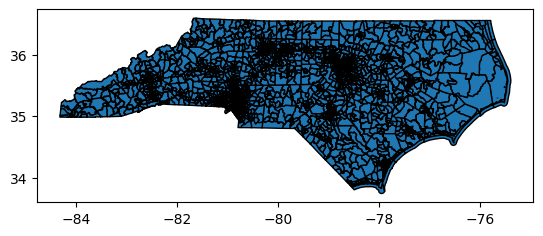

In [7]:
import os
import geopandas as gpd

arquivos = [os.path.join("/content", f) for f in os.listdir("/content") if f.endswith(".shp")]
arquivo = max(arquivos, key=os.path.getmtime)
tl = gpd.read_file(arquivo).to_crs("EPSG:4326")
tl.plot(edgecolor="black")


In [8]:
tl[["GEOID","geometry"]] ##TODO: Passar arquivo para HGI (CSV)

## BORO -> GEOID

,GEOID,geometry
0,37009970801,"POLYGON ((-81.43437 36.36623, -81.43436 36.366..."
1,37009970802,"POLYGON ((-81.4968 36.57366, -81.49674 36.5737..."
2,37009970502,"POLYGON ((-81.5225 36.45145, -81.52244 36.4516..."
3,37009970501,"POLYGON ((-81.48284 36.41024, -81.48265 36.410..."
4,37009970701,"POLYGON ((-81.64833 36.35459, -81.64823 36.355..."
...,...,...
2667,37063000900,"POLYGON ((-78.89438 35.99865, -78.89432 35.998..."
2668,37063001001,"POLYGON ((-78.88618 35.99051, -78.88615 35.990..."
2669,37063000600,"POLYGON ((-78.95831 35.99871, -78.95813 35.998..."
2670,37063000200,"POLYGON ((-78.90299 36.00574, -78.90253 36.006..."


In [9]:
import geopandas as gpd
from shapely import wkt

boroughs = tl[["GEOID", "geometry"]].copy()
boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)

boroughs.to_csv(f"{diretorio_principal}/boroughs_area.csv", index=False)


/tmp/ipython-input-2001046065.py:5: UserWarning: Geometry column does not contain geometry.
  boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)


In [10]:
boroughs

,GEOID,geometry
0,37009970801,"POLYGON ((-81.434372 36.366233, -81.434355 36...."
1,37009970802,"POLYGON ((-81.496796 36.573658, -81.496738 36...."
2,37009970502,"POLYGON ((-81.522496 36.451453, -81.522444 36...."
3,37009970501,"POLYGON ((-81.482839 36.410244, -81.482647 36...."
4,37009970701,"POLYGON ((-81.64833 36.354586, -81.648227 36.3..."
...,...,...
2667,37063000900,"POLYGON ((-78.894376 35.998652, -78.894317 35...."
2668,37063001001,"POLYGON ((-78.886179 35.990514, -78.886153 35...."
2669,37063000600,"POLYGON ((-78.958314 35.998711, -78.958127 35...."
2670,37063000200,"POLYGON ((-78.902994 36.005742, -78.902529 36...."


In [11]:
!rm -rf /usr/local/lib/python3.12/dist-packages/~orch*
!pip cache purge


Files removed: 14 (3.2 MB)


In [12]:
%pip -q install -U pip setuptools wheel
%pip -q uninstall -y torch torchvision torchaudio torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib
%pip -q install --no-cache-dir geopandas shapely libpysal h3 h3ronpy pyarrow scipy scikit-learn


In [13]:
%pip -q install --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cpu
%pip -q install --no-cache-dir pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.4.0+cpu.html


In [14]:
%cd {diretorio_principal}

/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main


## POI Embedding

In [15]:
FOLDER_ID_CRUS = "1cV807NNGn4gSDX-7fkJ83rlr0nRo4y89"
FOLDER_ID_SEPARATED = "1XUWhd59YDe8dSrTb6eZlLvhVcLSGpZ7n"

filename = f"checkins_{ESTADO}.csv"

path_crus = f"estados/crus/{filename}"
path_sep  = f"estados/separated/{filename}"

print("Baixando (crus)...")
download_from_folder_by_name(drive_service,FOLDER_ID_CRUS, filename, path_crus)

print("Baixando (separated)...")
download_from_folder_by_name(drive_service,FOLDER_ID_SEPARATED, filename, path_sep)

print("Concluído:", path_crus, "e", path_sep)


Baixando (crus)...
Baixando (separated)...
Concluído: estados/crus/checkins_North Carolina.csv e estados/separated/checkins_North Carolina.csv


In [16]:
import pandas as pd, numpy as np, ast
import geopandas as gpd
from shapely.geometry import Point


CHECKIN_NAO_CRU = f"estados/crus/checkins_{ESTADO}.csv"
CHECKIN_CRU     = f"estados/separated/checkins_{ESTADO}.csv"
OUT_POIS        = "pois_gowalla.csv"

df_labeled = pd.read_csv(CHECKIN_NAO_CRU)
df_raw     = pd.read_csv(CHECKIN_CRU)

lon_col_raw = "lng" if "lng" in df_raw.columns else "longitude"
lat_col_raw = "lat" if "lat" in df_raw.columns else "latitude"
lon_col_lab = "lng" if "lng" in df_labeled.columns else ("longitude" if "longitude" in df_labeled.columns else None)
lat_col_lab = "lat" if "lat" in df_labeled.columns else ("latitude" if "latitude" in df_labeled.columns else None)

def parse_names(cell):
    try:
        lst = ast.literal_eval(cell)
        if isinstance(lst, list):
            return [d.get("name") for d in lst if isinstance(d, dict) and "name" in d]
    except Exception:
        pass
    return []

df_raw["__cat_names"] = df_raw["spot_categories"].fillna("[]").apply(parse_names)

def first_or_none(lst):
    return lst[0] if (isinstance(lst, list) and len(lst) > 0) else None

df_raw["__fclass_name"] = df_raw["__cat_names"].apply(first_or_none)

fclass_by_place = (df_raw.dropna(subset=["__fclass_name"])
                          .groupby("placeid")["__fclass_name"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

cat_by_place = (df_labeled.dropna(subset=["category"])
                          .groupby("placeid")["category"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

coords_raw = (df_raw.groupby("placeid")[[lat_col_raw, lon_col_raw]]
                    .mean()
                    .rename(columns={lat_col_raw: "latitude", lon_col_raw: "longitude"}))

if coords_raw.empty and lon_col_lab and lat_col_lab and (lon_col_lab in df_labeled.columns) and (lat_col_lab in df_labeled.columns):
    coords_raw = (df_labeled.groupby("placeid")[[lat_col_lab, lon_col_lab]]
                           .mean()
                           .rename(columns={lat_col_lab: "latitude", lon_col_lab: "longitude"}))

coords_raw = coords_raw.dropna()

pois = pd.DataFrame({"feature_id": coords_raw.index})
pois["feature_id"] = pois["feature_id"].astype(int)

pois["fclass_name"]   = fclass_by_place.reindex(pois["feature_id"]).values
pois["category_name"] = cat_by_place.reindex(pois["feature_id"]).values

pois = pois.dropna(subset=["fclass_name", "category_name"]).reset_index(drop=True)

gdf = gpd.GeoDataFrame(
    pois,
    geometry=gpd.points_from_xy(coords_raw.loc[pois["feature_id"], "longitude"].values,
                                coords_raw.loc[pois["feature_id"], "latitude"].values),
    crs="EPSG:4326"
)
gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)

fclass_vocab = {n:i for i,n in enumerate(pd.Series(gdf["fclass_name"]).dropna().unique())}
cat_vocab    = {n:i for i,n in enumerate(pd.Series(gdf["category_name"]).dropna().unique())}

gdf["fclass"]   = gdf["fclass_name"].map(lambda n: fclass_vocab.get(n, -1)).astype(int)
gdf["category"] = gdf["category_name"].map(lambda n: cat_vocab.get(n, -1)).astype(int)

gdf = gdf[(gdf["fclass"]>=0) & (gdf["category"]>=0)].reset_index(drop=True)

pois_out = gdf[["feature_id", "category", "fclass", "geometry"]].copy()
pois_out.to_csv(OUT_POIS, index=False)



/tmp/ipython-input-2811998353.py:67: UserWarning: Geometry column does not contain geometry.
  gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)


In [ ]:
# @title
import geopandas as gpd
from shapely.geometry import box

lat_min, lat_max = df["latitude"].min(), df["latitude"].max()
lon_min, lon_max = df["longitude"].min(), df["longitude"].max()
area = box(lon_min, lat_min, lon_max, lat_max).buffer(0.01)

boroughs = gpd.GeoDataFrame(geometry=[area], crs="EPSG:4326")

boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)
boroughs.to_csv("boroughs_area.csv", index=False)


In [17]:
import sys
module_dir = f'{diretorio_principal}/region-embedding/baselines/poi-encoder'

sys.path.insert(0, module_dir)

In [18]:
from POIEmbedding import PreProcess

PreProcess("pois_gowalla.csv", "boroughs_area.csv", h3=False).run() ##TODO H3 FALSO


boroughs cols: ['GEOID', 'geometry']
         GEOID                                           geometry
0  37009970801  POLYGON ((-81.43437 36.36623, -81.43436 36.366...
1  37009970802  POLYGON ((-81.4968 36.57366, -81.49674 36.5737...
2  37009970502  POLYGON ((-81.5225 36.45145, -81.52244 36.4516...
3  37009970501  POLYGON ((-81.48284 36.41024, -81.48265 36.410...
4  37009970701  POLYGON ((-81.64833 36.35459, -81.64823 36.355...
            GEOID                                           geometry
0     37009970801  POLYGON ((-81.43437 36.36623, -81.43436 36.366...
1     37009970802  POLYGON ((-81.4968 36.57366, -81.49674 36.5737...
2     37009970502  POLYGON ((-81.5225 36.45145, -81.52244 36.4516...
3     37009970501  POLYGON ((-81.48284 36.41024, -81.48265 36.410...
4     37009970701  POLYGON ((-81.64833 36.35459, -81.64823 36.355...
...           ...                                                ...
2667  37063000900  POLYGON ((-78.89438 35.99865, -78.89432 35.998...
2668  370630010

In [19]:
import pandas as pd
import numpy as np
import torch
from shapely import wkt

def build_node_features_from_location_encoder(pois_csv_path: str,
                                              loc_embed_pt_path: str,
                                              placeid_col: str = "feature_id"):

    df_pois = pd.read_csv(pois_csv_path)
    if df_pois["geometry"].dtype == object:
        df_pois["geometry"] = df_pois["geometry"].apply(wkt.loads)

    blob = torch.load(loc_embed_pt_path, map_location="cpu")
    E = blob["embeddings"].detach().cpu().numpy()
    placeids = [str(p) for p in blob["placeids"]]
    placeid2idx = {pid: i for i, pid in enumerate(placeids)}

    ids = df_pois[placeid_col].astype(str).tolist()
    D = E.shape[1]
    X = np.zeros((len(ids), D), dtype=np.float32)

    for i, pid in enumerate(ids):
        idx = placeid2idx.get(pid)
        if idx is None:
            raise KeyError(f"placeid {pid} não encontrado em {loc_embed_pt_path}. "
                           f"")
        X[i] = E[idx]

    return X, df_pois


In [19]:
# @title
from POIEmbedding import POI2Vec
p = POI2Vec()
p.train()
p.save_walks()


       source  target    weight
0           0   14294  0.690752
1           0   17830  0.663977
2           0    1330  0.657998
3           0    6370  0.769956
4           0   13550  0.612949
...       ...     ...       ...
70624   23506   23508  0.202392
70625   23506   23520  0.202656
70626   23508   23520  0.631207
70627   23528   23536  0.816453
70628   23529   23530  0.627095

[70629 rows x 3 columns]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
# @title
from POIEmbedding import POI2Vec
from model import POISet, EmbeddingModel
import torch, torch.utils.data as tud

poi2vec = POI2Vec()
poi2vec.read_walks()
poi2vec.get_global_second_class_walks()

second_class_hierarchy_pairs = list(set([tuple(x) for x in poi2vec.pois[["category","fclass"]].to_numpy()]))
dataset = POISet(
    poi2vec.second_class_number,
    poi2vec.second_class_walks,
    poi2vec.global_second_class_walks,
    k=5
)
model = EmbeddingModel(
    vocab_size=poi2vec.second_class_number,
    embed_size=64,
    second_class_hierarchy_pairs=second_class_hierarchy_pairs,
    le_lambda=1e-8
)

loader = tud.DataLoader(dataset, batch_size=2048, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-2)
for e in range(5):
    for i,(inp,pos,neg) in enumerate(loader):
        opt.zero_grad()
        loss,_ = model(inp.long(), pos.long(), neg.long())
        loss.backward()
        opt.step()

torch.save({"in_embed.weight": model.clone_input_embedding()}, "poi-encoder-gowalla-h3.tensor")


       source  target    weight
0           0   14294  0.690752
1           0   17830  0.663977
2           0    1330  0.657998
3           0    6370  0.769956
4           0   13550  0.612949
...       ...     ...       ...
70624   23506   23508  0.202392
70625   23506   23520  0.202656
70626   23508   23520  0.631207
70627   23528   23536  0.816453
70628   23529   23530  0.627095

[70629 rows x 3 columns]


## HGI

In [20]:
import sys
module_dir = f'{diretorio_principal}/region-embedding/baselines/HGI/preprocess'

sys.path.insert(0, module_dir)

In [21]:
import torch, numpy as np, pandas as pd
from torch_geometric.data import Data
from main import Preprocess

POIS = "pois_gowalla.csv"
REGS = "boroughs_area.csv"

data_dict = Preprocess(POIS, REGS, emb_filename=None, h3=False).get_data_torch()

loc_pt_path = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/poi_embeddings_location.pt"
blob = torch.load(loc_pt_path, map_location="cpu")
E = blob["embeddings"].detach().cpu().numpy()
placeids = [str(p) for p in blob["placeids"]]
placeid2idx = {pid: i for i, pid in enumerate(placeids)}
D = E.shape[1]

order = pd.read_csv("poi_index.csv")
order["feature_id"] = order["feature_id"].astype(str)

X = np.zeros((len(order), D), dtype=np.float32)
for i, pid in enumerate(order["feature_id"].tolist()):
    idx = placeid2idx.get(pid)
    if idx is None:
        raise KeyError(f"placeid {pid} não encontrado em {loc_pt_path}. Gere embeddings para todos os POIs.")
    X[i] = E[idx]

import numpy as np
ei = np.asarray(data_dict['edge_index'])
assert ei.max() < X.shape[0], "edge_index referencia nó >= len(X) — ordem quebrou"

g = Data(
    x=torch.tensor(X, dtype=torch.float32),
    edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
    edge_weight=torch.tensor(data_dict['edge_weight'], dtype=torch.float32),
)
g.region_id  = torch.tensor(data_dict['region_id'], dtype=torch.long)
g.region_area = torch.tensor(data_dict['region_area'], dtype=torch.float32)
g.coarse_region_similarity = torch.tensor(data_dict['coarse_region_similarity'], dtype=torch.float32)
g.region_adjacency = torch.tensor(data_dict['region_adjacency'], dtype=torch.long)

torch.save(g, "gowalla.pt")


reading poi data
reading boroughs data


/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 2 islands with ids: 317, 1095.
  return W(neighbors, **kwargs)


reading boroughs data
creating graph
       feature_id  category  fclass                    geometry  index_right  \
0            9890         0       0  POINT (-80.84195 35.22812)         1631   
1           10705         0       1  POINT (-80.62493 35.49844)         2554   
2           10972         0       2  POINT (-79.04504 35.91776)         1335   
3           10973         1       3   POINT (-79.0491 35.90847)         2136   
4           10976         1       3    POINT (-79.05129 35.912)          429   
...           ...       ...     ...                         ...          ...   
23546     7569655         5     206  POINT (-78.68843 35.78272)          211   
23547     7570598         4     106  POINT (-78.73775 35.88456)         1671   
23548     7571076         5     125  POINT (-78.40888 33.89438)         2454   
23549     7575490         1      11   POINT (-78.6689 35.65512)          305   
23550     7579887         5     123  POINT (-78.89791 35.84705)         1383   

  

/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 2 islands with ids: 317, 1095.
  return W(neighbors, **kwargs)
/tmp/ipython-input-2460681102.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any

creating region similarity by cosine similarity of embeddings
finishing preprocessing


In [22]:
import os, pickle as pkl, torch
from torch_geometric.data import Data

os.makedirs("./data", exist_ok=True)

g = torch.load("./gowalla.pt", map_location="cpu")

data_dict = {
    "node_features": g.x.detach().cpu().numpy(),
    "edge_index": g.edge_index.detach().cpu().numpy(),
    "edge_weight": g.edge_weight.detach().cpu().numpy(),
    "region_id": g.region_id.detach().cpu().numpy(),
    "region_area": g.region_area.detach().cpu().numpy(),
    "coarse_region_similarity": g.coarse_region_similarity.detach().cpu().numpy(),
    "region_adjacency": g.region_adjacency.detach().cpu().numpy(),
}

with open("./data/gowalla_hgi_data.pkl", "wb") as f:
    pkl.dump(data_dict, f)



/tmp/ipython-input-1595378934.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load("./gowalla.pt", map_location="cpu")


In [23]:
import numpy as np

R_from_id = int(np.max(data_dict["region_id"])) + 1
R_area    = len(data_dict["region_area"])
R_adj     = int(data_dict["region_adjacency"].max()) + 1
R_sim     = data_dict["coarse_region_similarity"].shape[0]

print("R from id :", R_from_id)
print("R area    :", R_area)
print("R adj     :", R_adj)
print("R sim     :", R_sim)

assert R_from_id == R_area == R_adj == R_sim, "Desalinhad"


R from id : 2127
R area    : 2127
R adj     : 2127
R sim     : 2127


In [24]:
!python {diretorio_principal}/region-embedding/baselines/HGI/train.py --city gowalla --dim 64 --alpha 0.5 --attention_head 4 --epoch 300 --device cpu --save_name gowalla_h3


Streaming output truncated to the last 5000 lines.
        [ 0.0680,  0.0809,  0.0701,  ..., -0.0478,  0.0509,  0.0642]],
       requires_grad=True) Parameter containing:
tensor([[ 0.0226, -0.0115, -0.0897,  ...,  0.1097, -0.0640, -0.0572],
        [-0.0370,  0.0394,  0.0286,  ...,  0.0534,  0.1121, -0.0566],
        [ 0.0196, -0.0020,  0.0353,  ...,  0.0979,  0.0791,  0.0644],
        ...,
        [-0.0878,  0.0138,  0.0907,  ...,  0.0427, -0.0570,  0.0353],
        [-0.0852,  0.1026, -0.0687,  ...,  0.0915, -0.0320, -0.1195],
        [ 0.1529,  0.1253, -0.0166,  ..., -0.0235,  0.0305,  0.0601]],
       requires_grad=True)
Parameter containing:
tensor([[-0.0458, -0.0938,  0.0427,  ...,  0.0232, -0.0595, -0.0706],
        [-0.0998,  0.0643,  0.0341,  ..., -0.0617, -0.0709, -0.0271],
        [-0.1832,  0.0992,  0.0739,  ..., -0.0387,  0.0742,  0.0362],
        ...,
        [-0.1177, -0.1001,  0.0352,  ...,  0.0142, -0.0739,  0.0300],
        [-0.0943, -0.1597, -0.2204,  ..., -0.0536, -0